In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Step 1 - Read in Data
To get started, we need to import the results of scraping the individual racer pages. Each row represents an individual runner, and reviews are stored in a dictionary that needs to be unpacked with Python.

In [100]:
all_racers = pd.read_csv('./RaceRaves_data/Racers_All.csv')
all_racers = all_racers.drop('Unnamed: 0', axis=1)
all_racers.head()

,racer_id,location,state,region,since_date,affiliations,last active,clubs,rave_race,dream_race,run_because,past_races,reviews
0,090775candice,"Anaheim, CA",CA,US,Raving since 2017,NaN,active 1 year ago,[],NaN,Doing a spartan race.,I want to show people if you believe in yourse...,{'Tustin Hangar Half Marathon & 5K': {'name': ...,{'Tustin Hangar Half Marathon & 5K': [{'race_n...
1,16490derek,"Wilmot, Canada",Canada,Non-US,Raving since 2017,NaN,"active 4 months, 1 week ago",[],NaN,NaN,NaN,{'Hamilton Marathon Road2Hope': {'name': 'Hami...,{'Hamilton Marathon Road2Hope': [{'race_name':...
2,18anjel,"Chino, CA",CA,US,Raving since 2016,['Half Fanatic'],"active 2 years, 1 month ago",[],NaN,OC Marathon and Half,My family runs. We run as a family hobby.,{'Surf City Marathon & Half Marathon': {'name'...,{'Surf City Marathon & Half Marathon': [{'race...
3,1FlyMother,"Port Allegany, PA",PA,US,Raving since 2017,NaN,active 8 months ago,[],NaN,NaN,NaN,{'Presque Isle Half Marathon': {'name': 'Presq...,{'Presque Isle Half Marathon': [{'race_name': ...
4,1ladybugangel,"Oxnard, CA",CA,US,Raving since 2017,NaN,"active 4 months, 3 weeks ago",['Twisted Trail Runners and Twisted Trail run...,Spacerock 2017,"Valencia Trail Race March 31st, 2018",It makes me feel like I am alive and living in...,{'SPACEROCK Trail Race': {'name': 'SPACEROCK T...,{'SPACEROCK Trail Race': [{'race_name': 'SPACE...


In [101]:
all_racers.shape

(2010, 13)

There are some missing values that need to be dealt with. Affiliations were stored in a list, so we'll replace the NaN values with an empty list. The other missing values are strings that represent optional fields for the racers. Thus, a missing value means the racer chose not to provide the information, so we will replace those NaN values with "None".

In [104]:
all_racers['affiliations'] = all_racers['affiliations'].fillna('[]')
all_racers = all_racers.fillna('None')
all_racers.head()

,racer_id,location,state,region,since_date,affiliations,last active,clubs,rave_race,dream_race,run_because,past_races,reviews
0,090775candice,"Anaheim, CA",CA,US,Raving since 2017,[],active 1 year ago,[],None,Doing a spartan race.,I want to show people if you believe in yourse...,{'Tustin Hangar Half Marathon & 5K': {'name': ...,{'Tustin Hangar Half Marathon & 5K': [{'race_n...
1,16490derek,"Wilmot, Canada",Canada,Non-US,Raving since 2017,[],"active 4 months, 1 week ago",[],None,None,None,{'Hamilton Marathon Road2Hope': {'name': 'Hami...,{'Hamilton Marathon Road2Hope': [{'race_name':...
2,18anjel,"Chino, CA",CA,US,Raving since 2016,['Half Fanatic'],"active 2 years, 1 month ago",[],None,OC Marathon and Half,My family runs. We run as a family hobby.,{'Surf City Marathon & Half Marathon': {'name'...,{'Surf City Marathon & Half Marathon': [{'race...
3,1FlyMother,"Port Allegany, PA",PA,US,Raving since 2017,[],active 8 months ago,[],None,None,None,{'Presque Isle Half Marathon': {'name': 'Presq...,{'Presque Isle Half Marathon': [{'race_name': ...
4,1ladybugangel,"Oxnard, CA",CA,US,Raving since 2017,[],"active 4 months, 3 weeks ago",['Twisted Trail Runners and Twisted Trail run...,Spacerock 2017,"Valencia Trail Race March 31st, 2018",It makes me feel like I am alive and living in...,{'SPACEROCK Trail Race': {'name': 'SPACEROCK T...,{'SPACEROCK Trail Race': [{'race_name': 'SPACE...


Now we can check to make sure we have no missing values using .info:

In [105]:
all_racers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 13 columns):
racer_id        2010 non-null object
location        2010 non-null object
state           2010 non-null object
region          2010 non-null object
since_date      2010 non-null object
affiliations    2010 non-null object
last active     2010 non-null object
clubs           2010 non-null object
rave_race       2010 non-null object
dream_race      2010 non-null object
run_because     2010 non-null object
past_races      2010 non-null object
reviews         2010 non-null object
dtypes: object(13)
memory usage: 204.2+ KB


The website has seven affiliations that racers can choose, but our EDA showed 10 different values. Three of the values appear to be old options that got updated on the site at some point. We can create a function to clean that up. First, we need to use the __literal_eval__ function to turn the text in the csv into true lists in Python.

We also need to fix the clubs features, which has semi-colons separating values, instead of commas. There was also one record that happened to be an NaN that got switched to 'None', so we'll fix that before using __literal_eval__ to convert the string values to lists.

In [106]:
all_racers['affiliations'] = all_racers['affiliations'].map(literal_eval)

def fix_affiliations(list):
    new_list = []
    for item in list:
        if item == '50 states hopeful/finisher':
            new_list.append('50 states aspirant/finisher')
        elif item == 'Ironman triathlete':
            new_list.append('Ironman')
        elif item == 'Seven Continents Club member':
            new_list.append('Seven Continents Club')
        else:
            new_list.append(item)
    return new_list

all_racers['affiliations'] = all_racers['affiliations'].map(fix_affiliations)

all_racers['clubs'] = all_racers['clubs'].map(lambda x: str(x).replace(';', "','"))
all_racers['clubs'] = all_racers['clubs'].map(lambda x: '[]' if x == 'None' else x)
all_racers['clubs'] = all_racers['clubs'].map(literal_eval)

all_racers.head(10)

,racer_id,location,state,region,since_date,affiliations,last active,clubs,rave_race,dream_race,run_because,past_races,reviews
0,090775candice,"Anaheim, CA",CA,US,Raving since 2017,[],active 1 year ago,[],None,Doing a spartan race.,I want to show people if you believe in yourse...,{'Tustin Hangar Half Marathon & 5K': {'name': ...,{'Tustin Hangar Half Marathon & 5K': [{'race_n...
1,16490derek,"Wilmot, Canada",Canada,Non-US,Raving since 2017,[],"active 4 months, 1 week ago",[],None,None,None,{'Hamilton Marathon Road2Hope': {'name': 'Hami...,{'Hamilton Marathon Road2Hope': [{'race_name':...
2,18anjel,"Chino, CA",CA,US,Raving since 2016,[Half Fanatic],"active 2 years, 1 month ago",[],None,OC Marathon and Half,My family runs. We run as a family hobby.,{'Surf City Marathon & Half Marathon': {'name'...,{'Surf City Marathon & Half Marathon': [{'race...
3,1FlyMother,"Port Allegany, PA",PA,US,Raving since 2017,[],active 8 months ago,[],None,None,None,{'Presque Isle Half Marathon': {'name': 'Presq...,{'Presque Isle Half Marathon': [{'race_name': ...
4,1ladybugangel,"Oxnard, CA",CA,US,Raving since 2017,[],"active 4 months, 3 weeks ago",[Twisted Trail Runners and Twisted Trail runn...,Spacerock 2017,"Valencia Trail Race March 31st, 2018",It makes me feel like I am alive and living in...,{'SPACEROCK Trail Race': {'name': 'SPACEROCK T...,{'SPACEROCK Trail Race': [{'race_name': 'SPACE...
5,2tallfritz,"Auburn, IN",IN,US,Raving since 2014,"[Marathon Maniac, 50 states aspirant/finisher]","active 3 years, 4 months ago",[],Little Rock Marathon,Silver Falls Marathon,It keeps me (somewhat) sane and healthy.,{'Bobcat Trail Marathon': {'name': 'Bobcat Tra...,{'Bobcat Trail Marathon': [{'race_name': 'Bobc...
6,428lyman,"International Falls, MN",MN,US,Raving since 2017,[],active 10 months ago,[],None,None,None,"{'Fargo Marathon': {'name': 'Fargo Marathon', ...",{'Fargo Marathon': [{'race_name': 'Fargo Marat...
7,42kCookie,"Tracy, CA",CA,US,Raving since 2015,[Half Fanatic],"active 6 months, 1 week ago",[Mountain House Running Club],None,Escape from Alcatraz Triathlon,I can.,{'Rock ‘n’ Roll San Jose 1/2 Marathon': {'name...,{'Across the Bay 12K & 415K': [{'race_name': '...
8,42kStraley,"Shell Knob, MO",MO,US,Raving since 2017,[50 states aspirant/finisher],active 1 month ago,[],None,None,None,{'Run with the Wind 25K': {'name': 'Run with t...,{'Run with the Wind 25K': [{'race_name': 'Run ...
9,42kman,"Breckenridge, MN",MN,US,Raving since 2017,"[Boston Marathon finisher, 50 states aspirant/...","active 1 year, 1 month ago",[],None,THE WORLD MAJORS,I CAN!!!! I LOVE THE FEELING OF DOING SOMETHIN...,{'Athens Marathon. The Authentic': {'name': 'A...,{'Athens Marathon. The Authentic': [{'race_nam...


The affiliations may be useful for modeling and profiling, so we need to convert the string values to numerics. And since racers can choose multiple affiliations, we want to have a column for each feature anyway. So we'll create dummies for each of the seven affiliations.

In [107]:
affiliation_dummies = pd.get_dummies(pd.DataFrame(all_racers['affiliations'].tolist()).stack()).sum(level=0)
all_racers = pd.merge(left=all_racers, right=affiliation_dummies,
                      left_index=True, right_index=True, how='left')
all_racers = all_racers.drop('affiliations', axis=1)
all_racers = all_racers.fillna(0)
all_racers.head()

,racer_id,location,state,region,since_date,last active,clubs,rave_race,dream_race,run_because,past_races,reviews,100 Half Marathons Club,50 states aspirant/finisher,Boston Marathon finisher,Half Fanatic,Ironman,Marathon Maniac,Seven Continents Club
0,090775candice,"Anaheim, CA",CA,US,Raving since 2017,active 1 year ago,[],None,Doing a spartan race.,I want to show people if you believe in yourse...,{'Tustin Hangar Half Marathon & 5K': {'name': ...,{'Tustin Hangar Half Marathon & 5K': [{'race_n...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16490derek,"Wilmot, Canada",Canada,Non-US,Raving since 2017,"active 4 months, 1 week ago",[],None,None,None,{'Hamilton Marathon Road2Hope': {'name': 'Hami...,{'Hamilton Marathon Road2Hope': [{'race_name':...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18anjel,"Chino, CA",CA,US,Raving since 2016,"active 2 years, 1 month ago",[],None,OC Marathon and Half,My family runs. We run as a family hobby.,{'Surf City Marathon & Half Marathon': {'name'...,{'Surf City Marathon & Half Marathon': [{'race...,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1FlyMother,"Port Allegany, PA",PA,US,Raving since 2017,active 8 months ago,[],None,None,None,{'Presque Isle Half Marathon': {'name': 'Presq...,{'Presque Isle Half Marathon': [{'race_name': ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1ladybugangel,"Oxnard, CA",CA,US,Raving since 2017,"active 4 months, 3 weeks ago",[Twisted Trail Runners and Twisted Trail runn...,Spacerock 2017,"Valencia Trail Race March 31st, 2018",It makes me feel like I am alive and living in...,{'SPACEROCK Trail Race': {'name': 'SPACEROCK T...,{'SPACEROCK Trail Race': [{'race_name': 'SPACE...,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Clubs is a free-form field on the site, so it's not clear what sort of patterns we might see there. Let's get a counts of the top clubs to see if there's anything valuable there.

In [108]:
clubs = []
for i in range(len(all_racers)):
    club_list = all_racers.iloc[i]['clubs']
    if club_list != []:
        for j in range(len(club_list)):
            clubs.append(club_list[j])
clubs_df = pd.DataFrame(clubs, columns=['club'])
clubs_df['club'].value_counts().head()

A Snail's Pace                 14
AREC                           13
Marathon Maniacs                8
A Snail's Pace Running Club     7
Half Fanatics                   6
Name: club, dtype: int64

That's clearly a dead-end, with only 2 clubs in the double-digits. We can ignore this variable.

## Step 2 - Extracting reviews
Now that we have clean data for each of the racers, we need to get their review data out of the dictionaries they're stored in. The first step is applying the __literal_eval__ function as we did for the list features. Then we'll create a separate row for each review and build out a dataframe for all reviews.

In [109]:
race_review_df = pd.DataFrame()
for i in range(len(all_racers)):
    try:
        review_dict = literal_eval(all_racers['reviews'].iloc[i])
        for key, value in review_dict.items():
            new_row = pd.DataFrame(value[0], index = [key])
            new_row['racer_id'] = all_racers.iloc[i]['racer_id']
            race_review_df = pd.concat([race_review_df, new_row])
    except:
        continue
race_review_df = race_review_df.reset_index(drop=True)
race_review_df.head()

,date,diff_rating,distance,overall_rating,prod_rating,race_name,scenery_rating,swag_rating,text,title,type,racer_id
0,"Mar 15, 2017",3.0,5K,4.0,4.0,Tustin Hangar Half Marathon & 5K,4.0,4.0,Have to do it again next year. My daughter an...,It was amazing to see inside the hanger,First-timer '17,090775candice
1,"Feb 7, 2017",5.0,Half Marathon,5.0,5.0,Surf City Marathon & Half Marathon,5.0,5.0,For my first half marathon I would love to sa...,This was my first half marathon.,First-timer '17,090775candice
2,"Nov 17, 2017",4.0,Marathon,5.0,5.0,Hamilton Marathon Road2Hope,4.0,3.0,Hamilton is an intimate race gathering with a...,Canada's top marathon,First-timer '17,16490derek
3,"Feb 13, 2016",1.0,Half Marathon,5.0,4.0,Surf City Marathon & Half Marathon,5.0,4.0,"The most stand-out, amazing part of this race...",A summary of California life in one race,First-timer '16,18anjel
4,"Feb 13, 2016",3.0,10K,3.0,4.0,Mission Inn Run,4.0,2.0,"For the price you pay for this run, it is wor...",Good for the money,First-timer '15,18anjel


In [110]:
race_review_df.shape

(6414, 12)

From our 2,010 racers we have 6,414 total reviews to work with. Looking at this data, we can see that it is very complete and clean - the website clearly ensures that users fill in all of the fields before submitting a review, which is great for us.

The only issue is the race distance field. The data includes 135 different distances, and 58 of those have only a single review. We only care about the distances people are most likely to run when looking at racer profiles and recommendations. Let's limit the options to those that have at least 20 reviews and lump the rest into "Other". We'll call the new feature 'distance_trunc'.

In [1]:
distances = race_review_df['distance'].value_counts()[race_review_df['distance'].value_counts() > 20].index
distances

NameError: name 'race_review_df' is not defined

In [112]:
def create_distance_trunc(distance):
    if distance in distances:
        return distance
    else:
        return 'Other'

race_review_df['distance_trunc'] = race_review_df['distance'].map(create_distance_trunc)
race_review_df.head()

,date,diff_rating,distance,overall_rating,prod_rating,race_name,scenery_rating,swag_rating,text,title,type,racer_id,distance_trunc
0,"Mar 15, 2017",3.0,5K,4.0,4.0,Tustin Hangar Half Marathon & 5K,4.0,4.0,Have to do it again next year. My daughter an...,It was amazing to see inside the hanger,First-timer '17,090775candice,5K
1,"Feb 7, 2017",5.0,Half Marathon,5.0,5.0,Surf City Marathon & Half Marathon,5.0,5.0,For my first half marathon I would love to sa...,This was my first half marathon.,First-timer '17,090775candice,Half Marathon
2,"Nov 17, 2017",4.0,Marathon,5.0,5.0,Hamilton Marathon Road2Hope,4.0,3.0,Hamilton is an intimate race gathering with a...,Canada's top marathon,First-timer '17,16490derek,Marathon
3,"Feb 13, 2016",1.0,Half Marathon,5.0,4.0,Surf City Marathon & Half Marathon,5.0,4.0,"The most stand-out, amazing part of this race...",A summary of California life in one race,First-timer '16,18anjel,Half Marathon
4,"Feb 13, 2016",3.0,10K,3.0,4.0,Mission Inn Run,4.0,2.0,"For the price you pay for this run, it is wor...",Good for the money,First-timer '15,18anjel,10K


In [113]:
race_review_df['distance_trunc'].value_counts()

Half Marathon           2907
Marathon                1334
5K                       691
10K                      553
Other                    404
50K                      131
10 Miler                  85
15K                       79
12K                       55
5 Miler                   35
50 Miler                  29
Marathon Relay            24
Half Marathon Relay       23
25K                       22
4 Miler                   21
8K                        21
Name: distance_trunc, dtype: int64

Now let's look at review counts for racers and races.

In [114]:
race_review_df['racer_id'].value_counts().describe()

count    2009.000000
mean        3.192633
std         6.181616
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        88.000000
Name: racer_id, dtype: float64

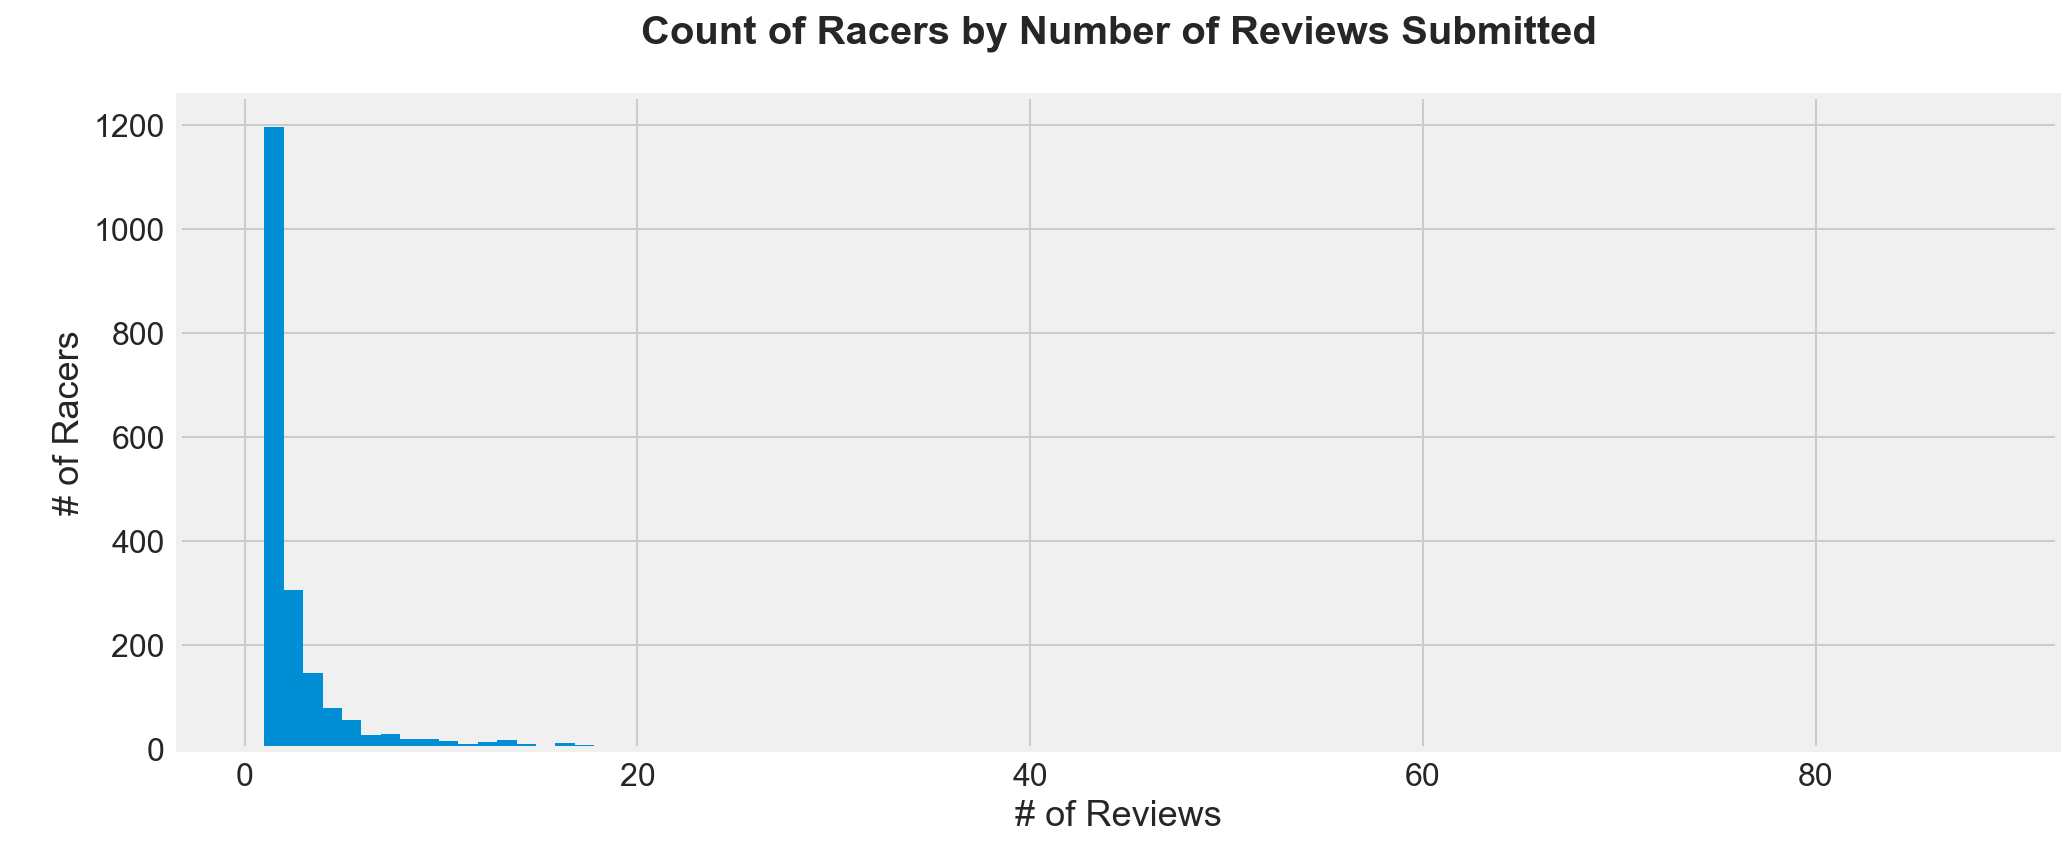

In [115]:
plt.figure(figsize=(15, 6))
plt.hist(race_review_df['racer_id'].value_counts(), bins=88)
plt.title('Count of Racers by Number of Reviews Submitted\n', fontsize=20, weight='bold')
plt.xlabel('# of Reviews', fontsize=18)
plt.ylabel('\n# of Racers', fontsize=18)
plt.tick_params(labelsize=16)
plt.savefig('./plots/racer_review_counts.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

In [116]:
race_review_df['race_name'].value_counts().describe()

count    2103.000000
mean        3.049929
std         6.031781
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        89.000000
Name: race_name, dtype: float64

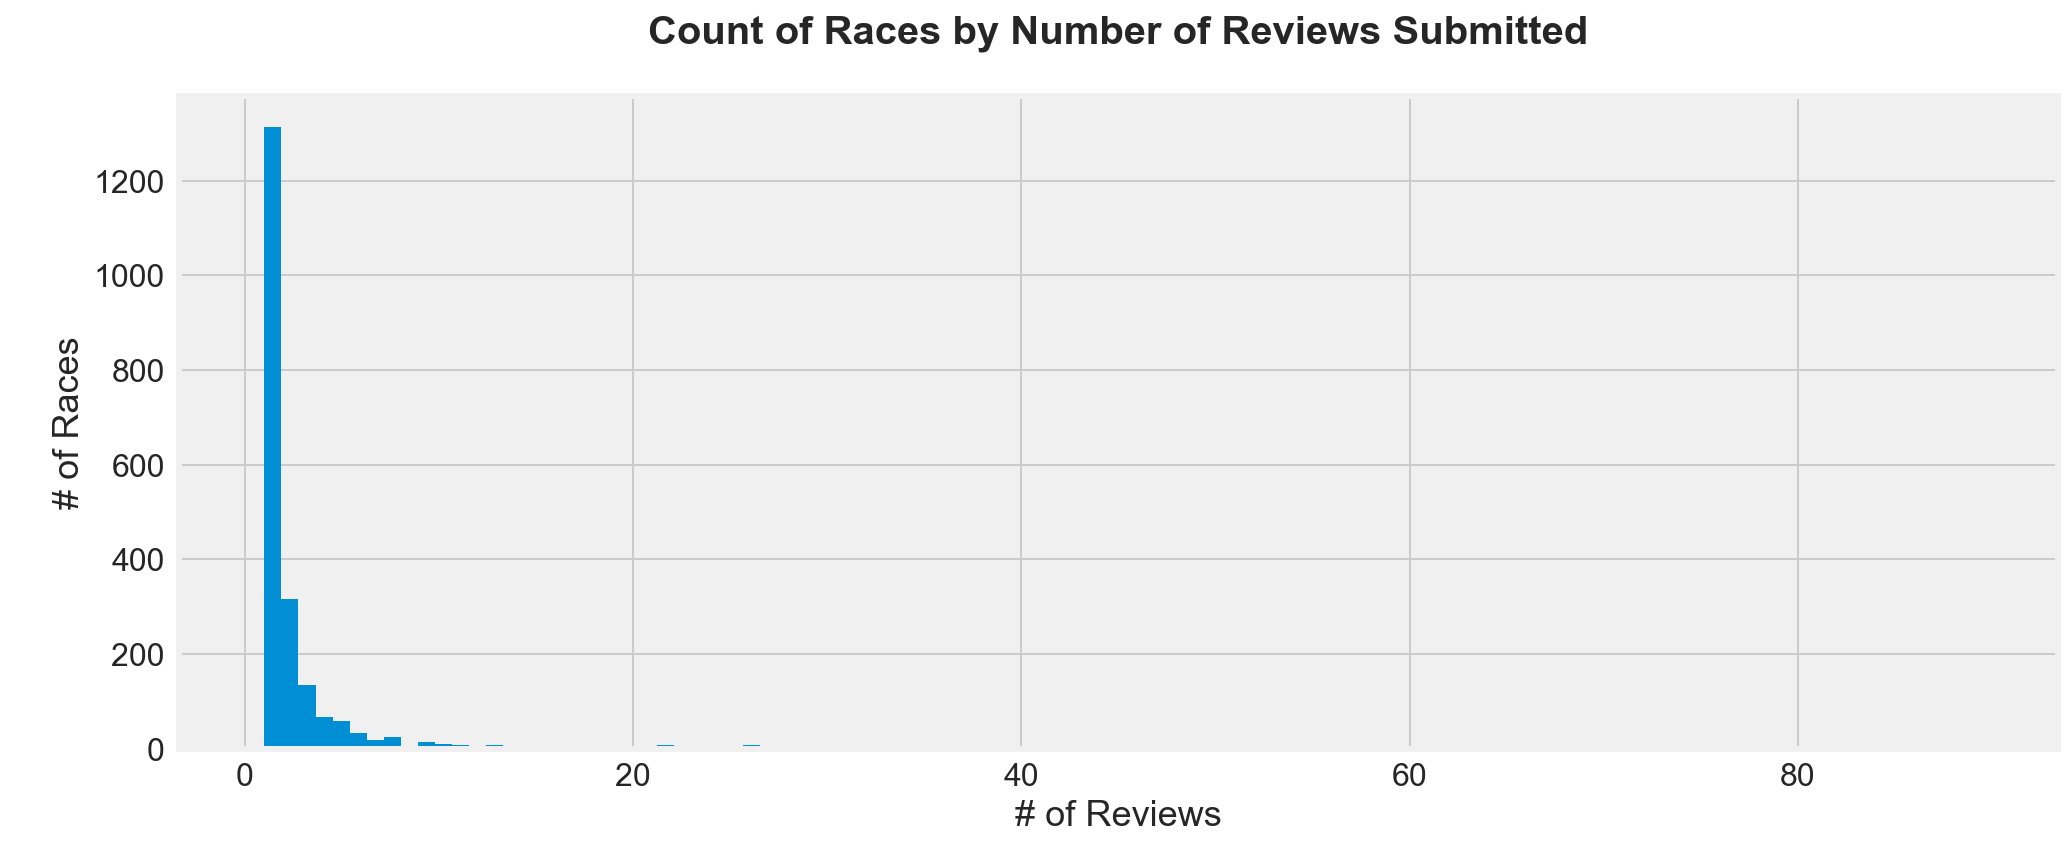

In [117]:
plt.figure(figsize=(15, 6))
plt.hist(race_review_df['race_name'].value_counts(), bins=100)
plt.title('Count of Races by Number of Reviews Submitted\n', fontsize=20, weight='bold')
plt.xlabel('# of Reviews', fontsize=18)
plt.ylabel('\n# of Races', fontsize=18)
plt.tick_params(labelsize=16)
plt.savefig('./plots/race_review_counts.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True);

Unfortunatly, more than half of racers and races have only one review. It would be more powerful to have multiple reviews on both sides, but we'll see how we can do with the data we have.

Next, we can look at the ratings. Reviewers have to provide 5 different ratings - Overall, Difficulty, Production, Scenery, and Swag. Let's see how they compare.

In [118]:
ratings = ['overall_rating', 'diff_rating', 'prod_rating', 'scenery_rating', 'swag_rating']
race_review_df[ratings].describe(percentiles=[0.05, 0.1, 0.2, 0.25, 0.5, 0.75]).T

,count,mean,std,min,5%,10%,20%,25%,50%,75%,max
overall_rating,6414.0,4.222638,0.868931,1.0,3.0,3.0,4.0,4.0,4.0,5.0,5.0
diff_rating,6414.0,2.917992,1.198709,1.0,1.0,1.0,2.0,2.0,3.0,4.0,5.0
prod_rating,6414.0,4.216869,0.970429,1.0,2.0,3.0,4.0,4.0,4.0,5.0,5.0
scenery_rating,6414.0,3.919395,1.065991,1.0,2.0,2.0,3.0,3.0,4.0,5.0,5.0
swag_rating,6414.0,3.873558,1.098491,1.0,2.0,2.0,3.0,3.0,4.0,5.0,5.0


In [119]:
for rating in ratings:
    num_fives = race_review_df[race_review_df[rating] == 5][rating].count()
    print('Number of 5 ratings for {}:'.format(rating), num_fives)
    print('% of 5 ratings for {}: '.format(rating), round(100*num_fives/6414, 1), "%", sep='')
    print()

Number of 5 ratings for overall_rating: 2868
% of 5 ratings for overall_rating: 44.7%

Number of 5 ratings for diff_rating: 671
% of 5 ratings for diff_rating: 10.5%

Number of 5 ratings for prod_rating: 3180
% of 5 ratings for prod_rating: 49.6%

Number of 5 ratings for scenery_rating: 2399
% of 5 ratings for scenery_rating: 37.4%

Number of 5 ratings for swag_rating: 2328
% of 5 ratings for swag_rating: 36.3%



Overall and Production ratings are the most likely to get a 5, with half of reviewers giving races a 5 on production. Scenery and Swag are less likely to get the top rating, and Difficulty rarely gets rated a 5. It makes sense that racers wouldn't be rating difficulty high - most people don't want to run the most difficult race.

Let's look at plots of the full distribution for each, and then explore the correlation between ratings.

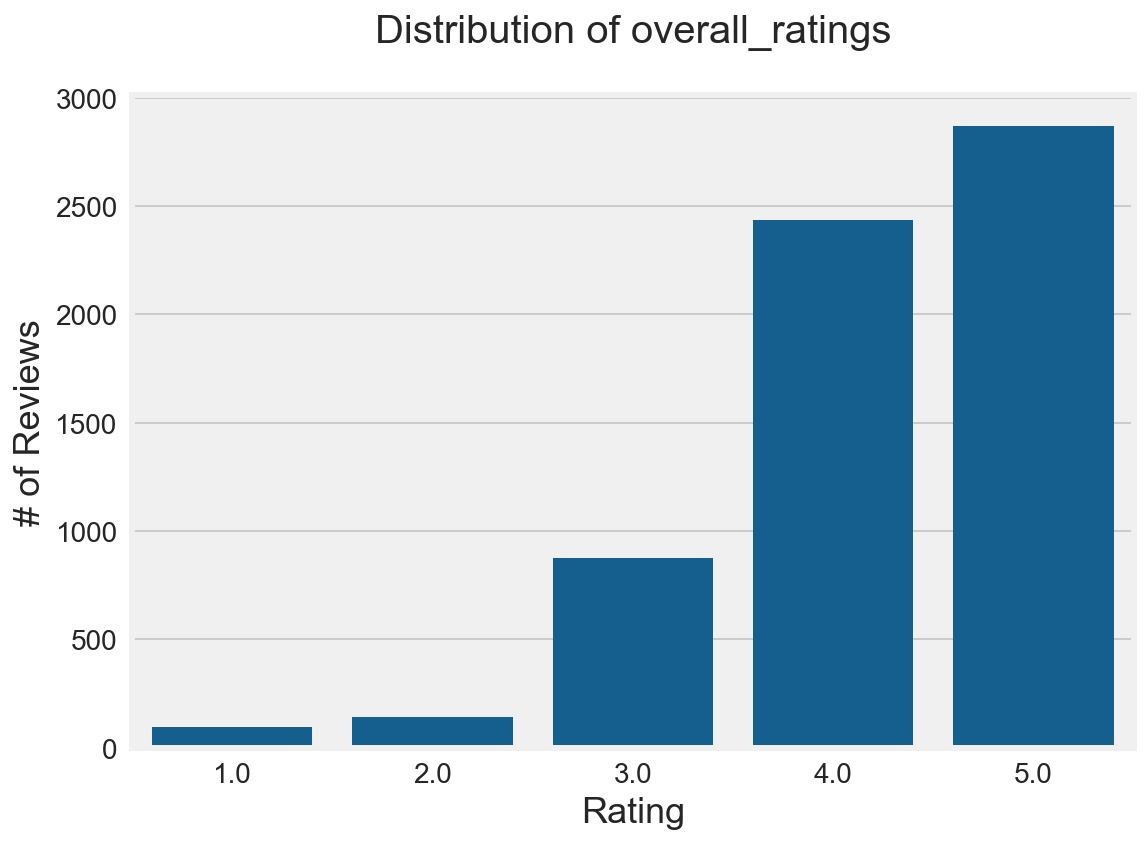

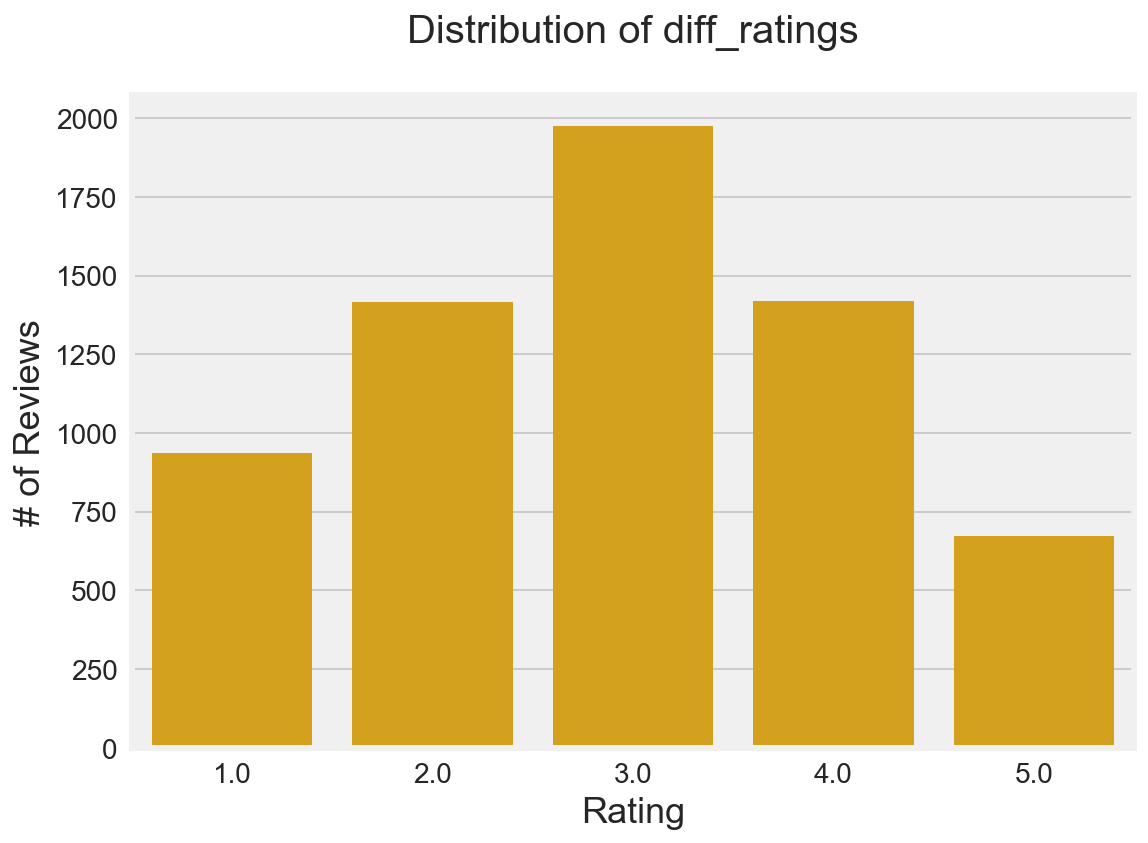

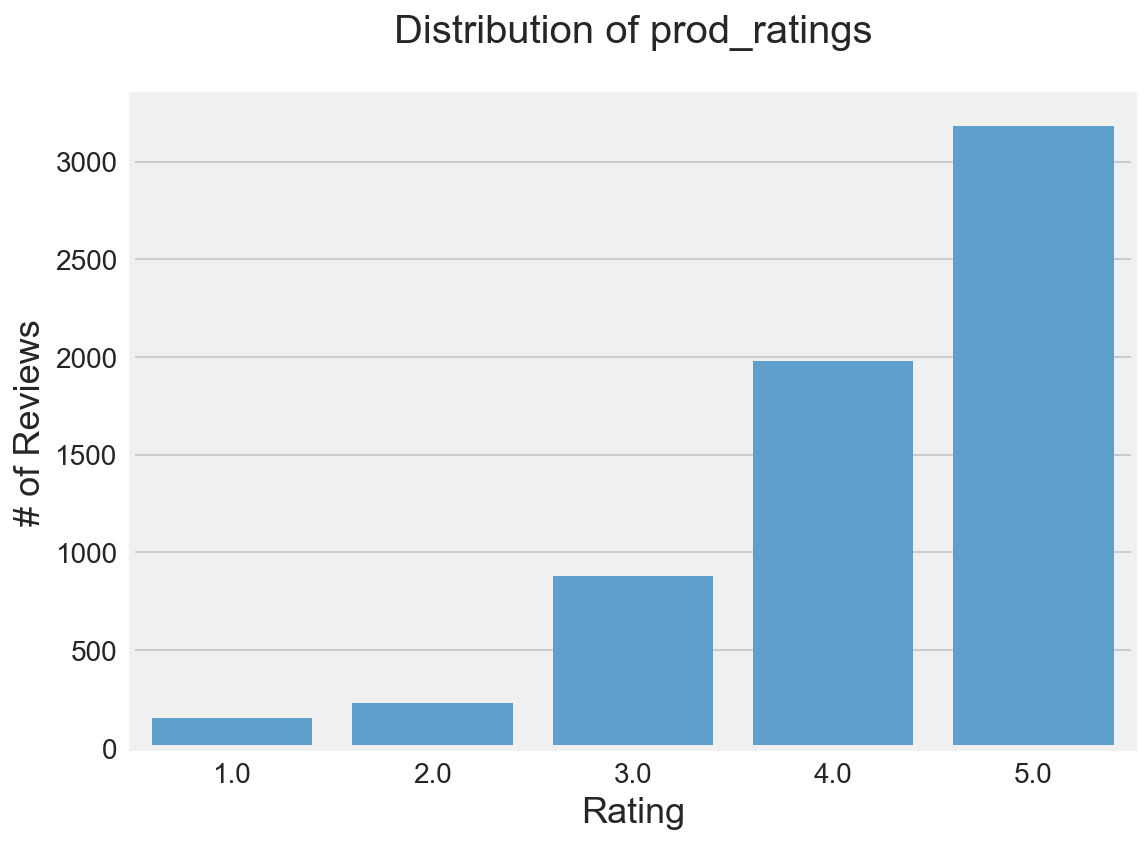

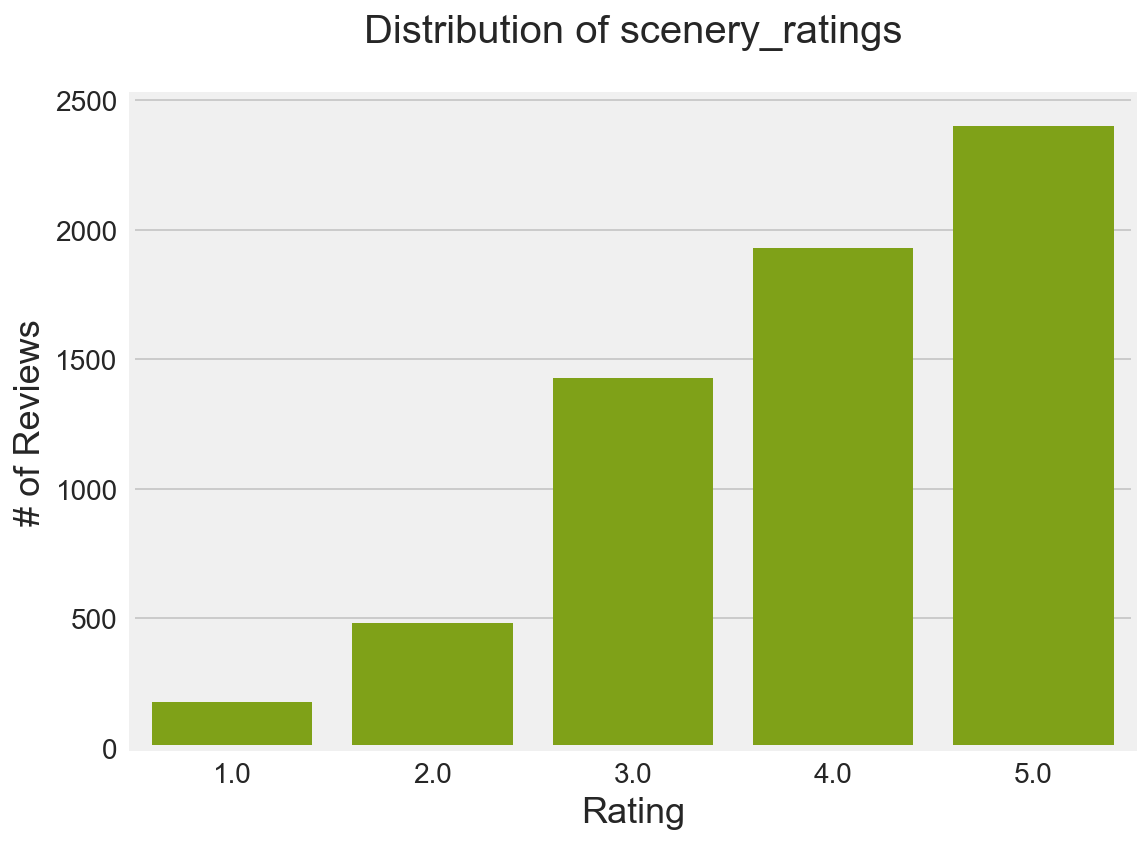

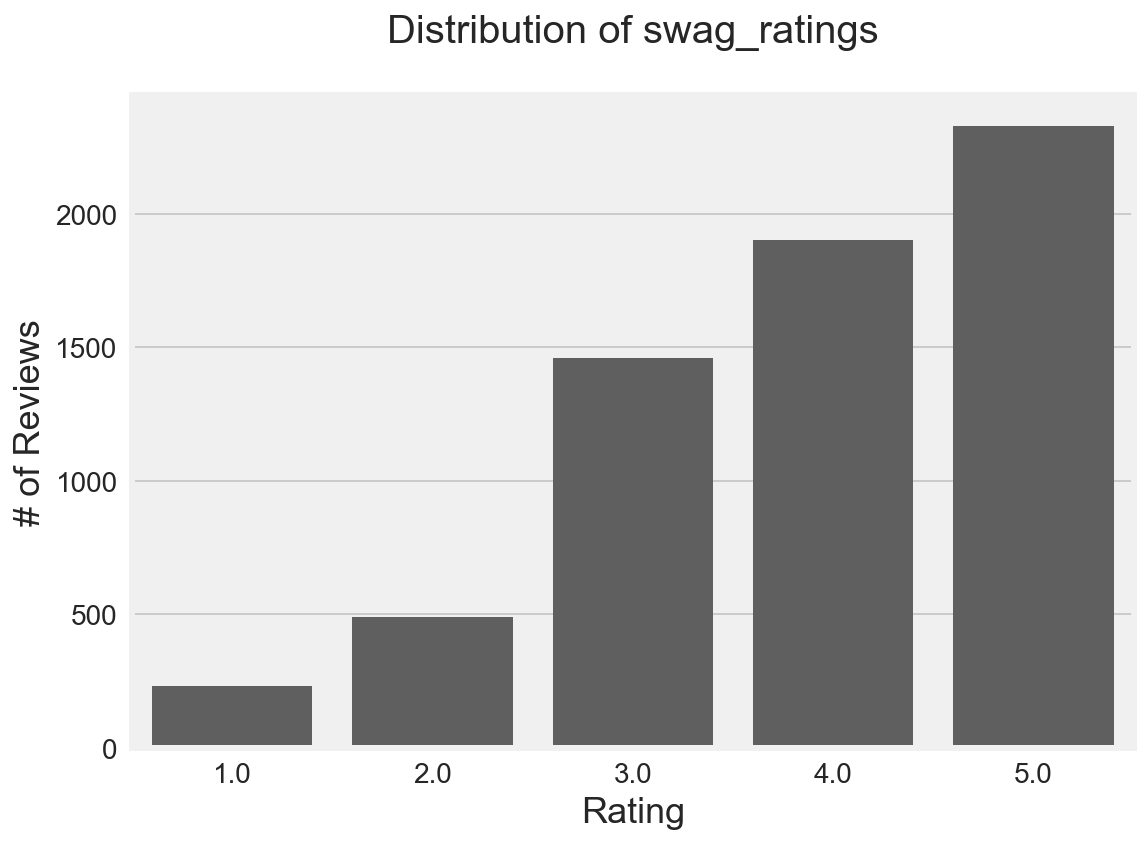

In [120]:
colors = ['#0064A2', '#F2AE00', '#4DA2DD', '#8AB801', '#5F5F5F']
color_dict = {}
i = 0
for rating in ratings:
    color_dict[rating] = colors[i]
    i += 1

for rating in ratings:
    plt.figure(figsize=(8, 6))
    sns.countplot(race_review_df[rating], color=color_dict[rating])
    plt.title('Distribution of {}s\n'.format(rating), fontsize=20)
    plt.xlabel('Rating', fontsize=18)
    plt.ylabel('# of Reviews', fontsize=18)
    plt.tick_params(labelsize=14)
    plot_file = './plots/' + rating + '.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight', pad_inches=1, transparent=True, frameon=False)

In [121]:
race_review_df[ratings].corr()

,overall_rating,diff_rating,prod_rating,scenery_rating,swag_rating
overall_rating,1.000000,0.156160,0.694811,0.483673,0.523347
diff_rating,0.156160,1.000000,0.126685,0.332853,0.113269
prod_rating,0.694811,0.126685,1.000000,0.328325,0.533458
scenery_rating,0.483673,0.332853,0.328325,1.000000,0.253896
swag_rating,0.523347,0.113269,0.533458,0.253896,1.000000


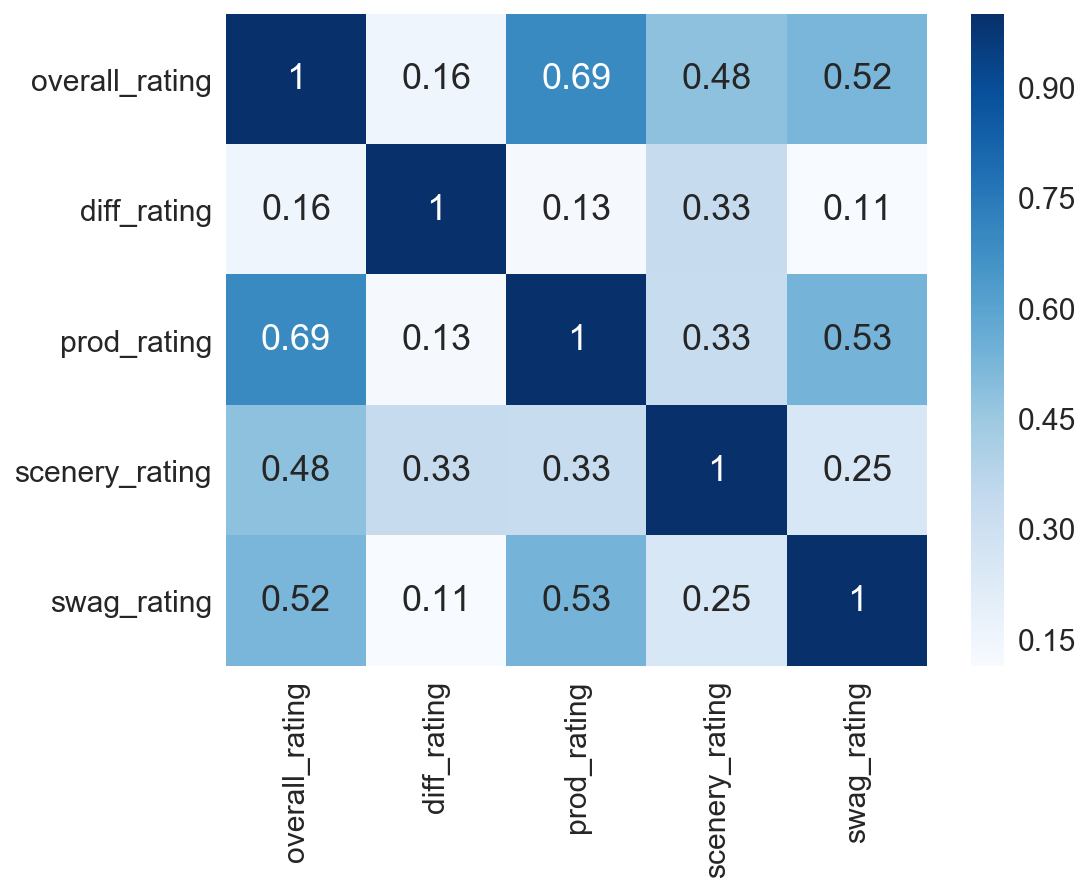

In [122]:
plt.figure(figsize=(7, 6))
sns.set(font_scale=1.5)
sns.heatmap(race_review_df[ratings].corr(), annot=True, cmap='Blues')
plt.savefig('./plots/ratings_heatmap.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=1)

The Overall rating is most highly correlated with Production, which makes sense - a well organized race is going to make the average racer pretty happy, regardless of the scenery or swag. Scenery and Swag also have strong correlation with Overall, but Difficulty has a much lower impact.

We can use linear regression to measure how much these factors drive the overall ratings.

In [123]:
linear = LinearRegression()
y = race_review_df['overall_rating']
X = race_review_df[['prod_rating']]
linear.fit(X, y)
linear.score(X, y)

0.48276275562529697

In [124]:
linear = LinearRegression()
y = race_review_df['overall_rating']
X = race_review_df[['diff_rating', 'prod_rating', 'scenery_rating', 'swag_rating']]
linear.fit(X, y)
linear.score(X, y)

0.5802681984348301

When we use only the Production rating to predict Overall, we get an R-squared of 48.3%, so production accounts for almost 50% of the overall rating for a race. Adding in the other factors only increases R-squared by 10%.

## Step 3 - Building the Recommender
In order to build a recommender based on reviews, we need to do some Natural Language Processing, starting with Count Vectorization. After a few iterations, we came up with some custom stop words. And instead of using a standard stemmer, we can use a custom standardizer to make sure the terms are consistent.

In [125]:
my_stopwords = stopwords.words('english') + \
              ['10k', '5k', 'marathon', 'becaus', 'mile', 'join', 'ultra', 'ive', 'takes', \
               '000', '5', '10', '13', '15', '20', '26', '30', '45', '50', '100', \
               '500', '00', '12', '24', '25', '31', '42', '195', '25k', '50k', '131', '262']

In [126]:
fix_word_dict = {
    'station': 'stations',
    'water': 'aid',
    'stops': 'stations',
    'tech': 'technical',
    'way': 'course',
    'pick': 'pickup',
    'started': 'start',
    'starts': 'start',
    'participants': 'finishers',
    'running': 'run',
    'runners': 'run',
    'walkers': 'walk',
    'finisher': 'finishers',
    'finishes': 'finish',
    'take': 'takes'
}
def fix_words(word):
    try:
        return fix_word_dict[word]
    except:
        return word

reviews = list(race_review_df['text'])
for i in range(len(reviews)):
    review_split = reviews[i].split(" ")
    review_fixed = [fix_words(''.join(e for e in word if e.isalnum())) for word in review_split]
    review_joined = " ".join(review_fixed)
    reviews[i] = review_joined
race_review_df['text'] = reviews

Next, for the purpose of validation of our recommender, we'll randomly select 80% of the racers to be the training dataset, and 20% for the validation holdout. We'll only keep reviews from the 80% training population, even for races that are reviewed by the other 20%.

In [127]:
deduped_racers = race_review_df['racer_id'].drop_duplicates().copy()
train_racers = pd.DataFrame(deduped_racers.sample(frac=0.80, random_state=28), columns=['racer_id'])
test_racers = pd.DataFrame(deduped_racers.drop(train_racers.index), columns=['racer_id'])

race_review_test = pd.merge(left=race_review_df, right=test_racers, on='racer_id')
race_review_train = pd.merge(left=race_review_df, right=train_racers, on='racer_id')
print('Train Shape:', race_review_train.shape)
print('Test Shape:', race_review_test.shape)

Train Shape: (5057, 13)
Test Shape: (1357, 13)


### Count Vectorizer 
Next, we use CountVectorizer to count up the bi-grams in the review data. Bi-grams were chosen because they most naturally reflect the themes that tend to be mentioned in race reviews.

In [128]:
review_vect = CountVectorizer(ngram_range=(2, 2), stop_words=my_stopwords, min_df=25, max_df=0.25)
X = review_vect.fit_transform(race_review_train['text'])

review_vect_df = pd.DataFrame(X.toarray(), columns=review_vect.get_feature_names())
review_vect_names = review_vect.get_feature_names()
review_vect_df.head()

,able run,age group,aid bottle,aid gatorade,aid sports,aid stations,aid stop,along beach,along course,along river,...,would run,year course,year race,year ran,year run,year year,years ago,years race,youre looking,youre run
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After applying the Count Vectorizer, we can look at the most common bi-grams in the review data to ensure they reflect themes we would expect.

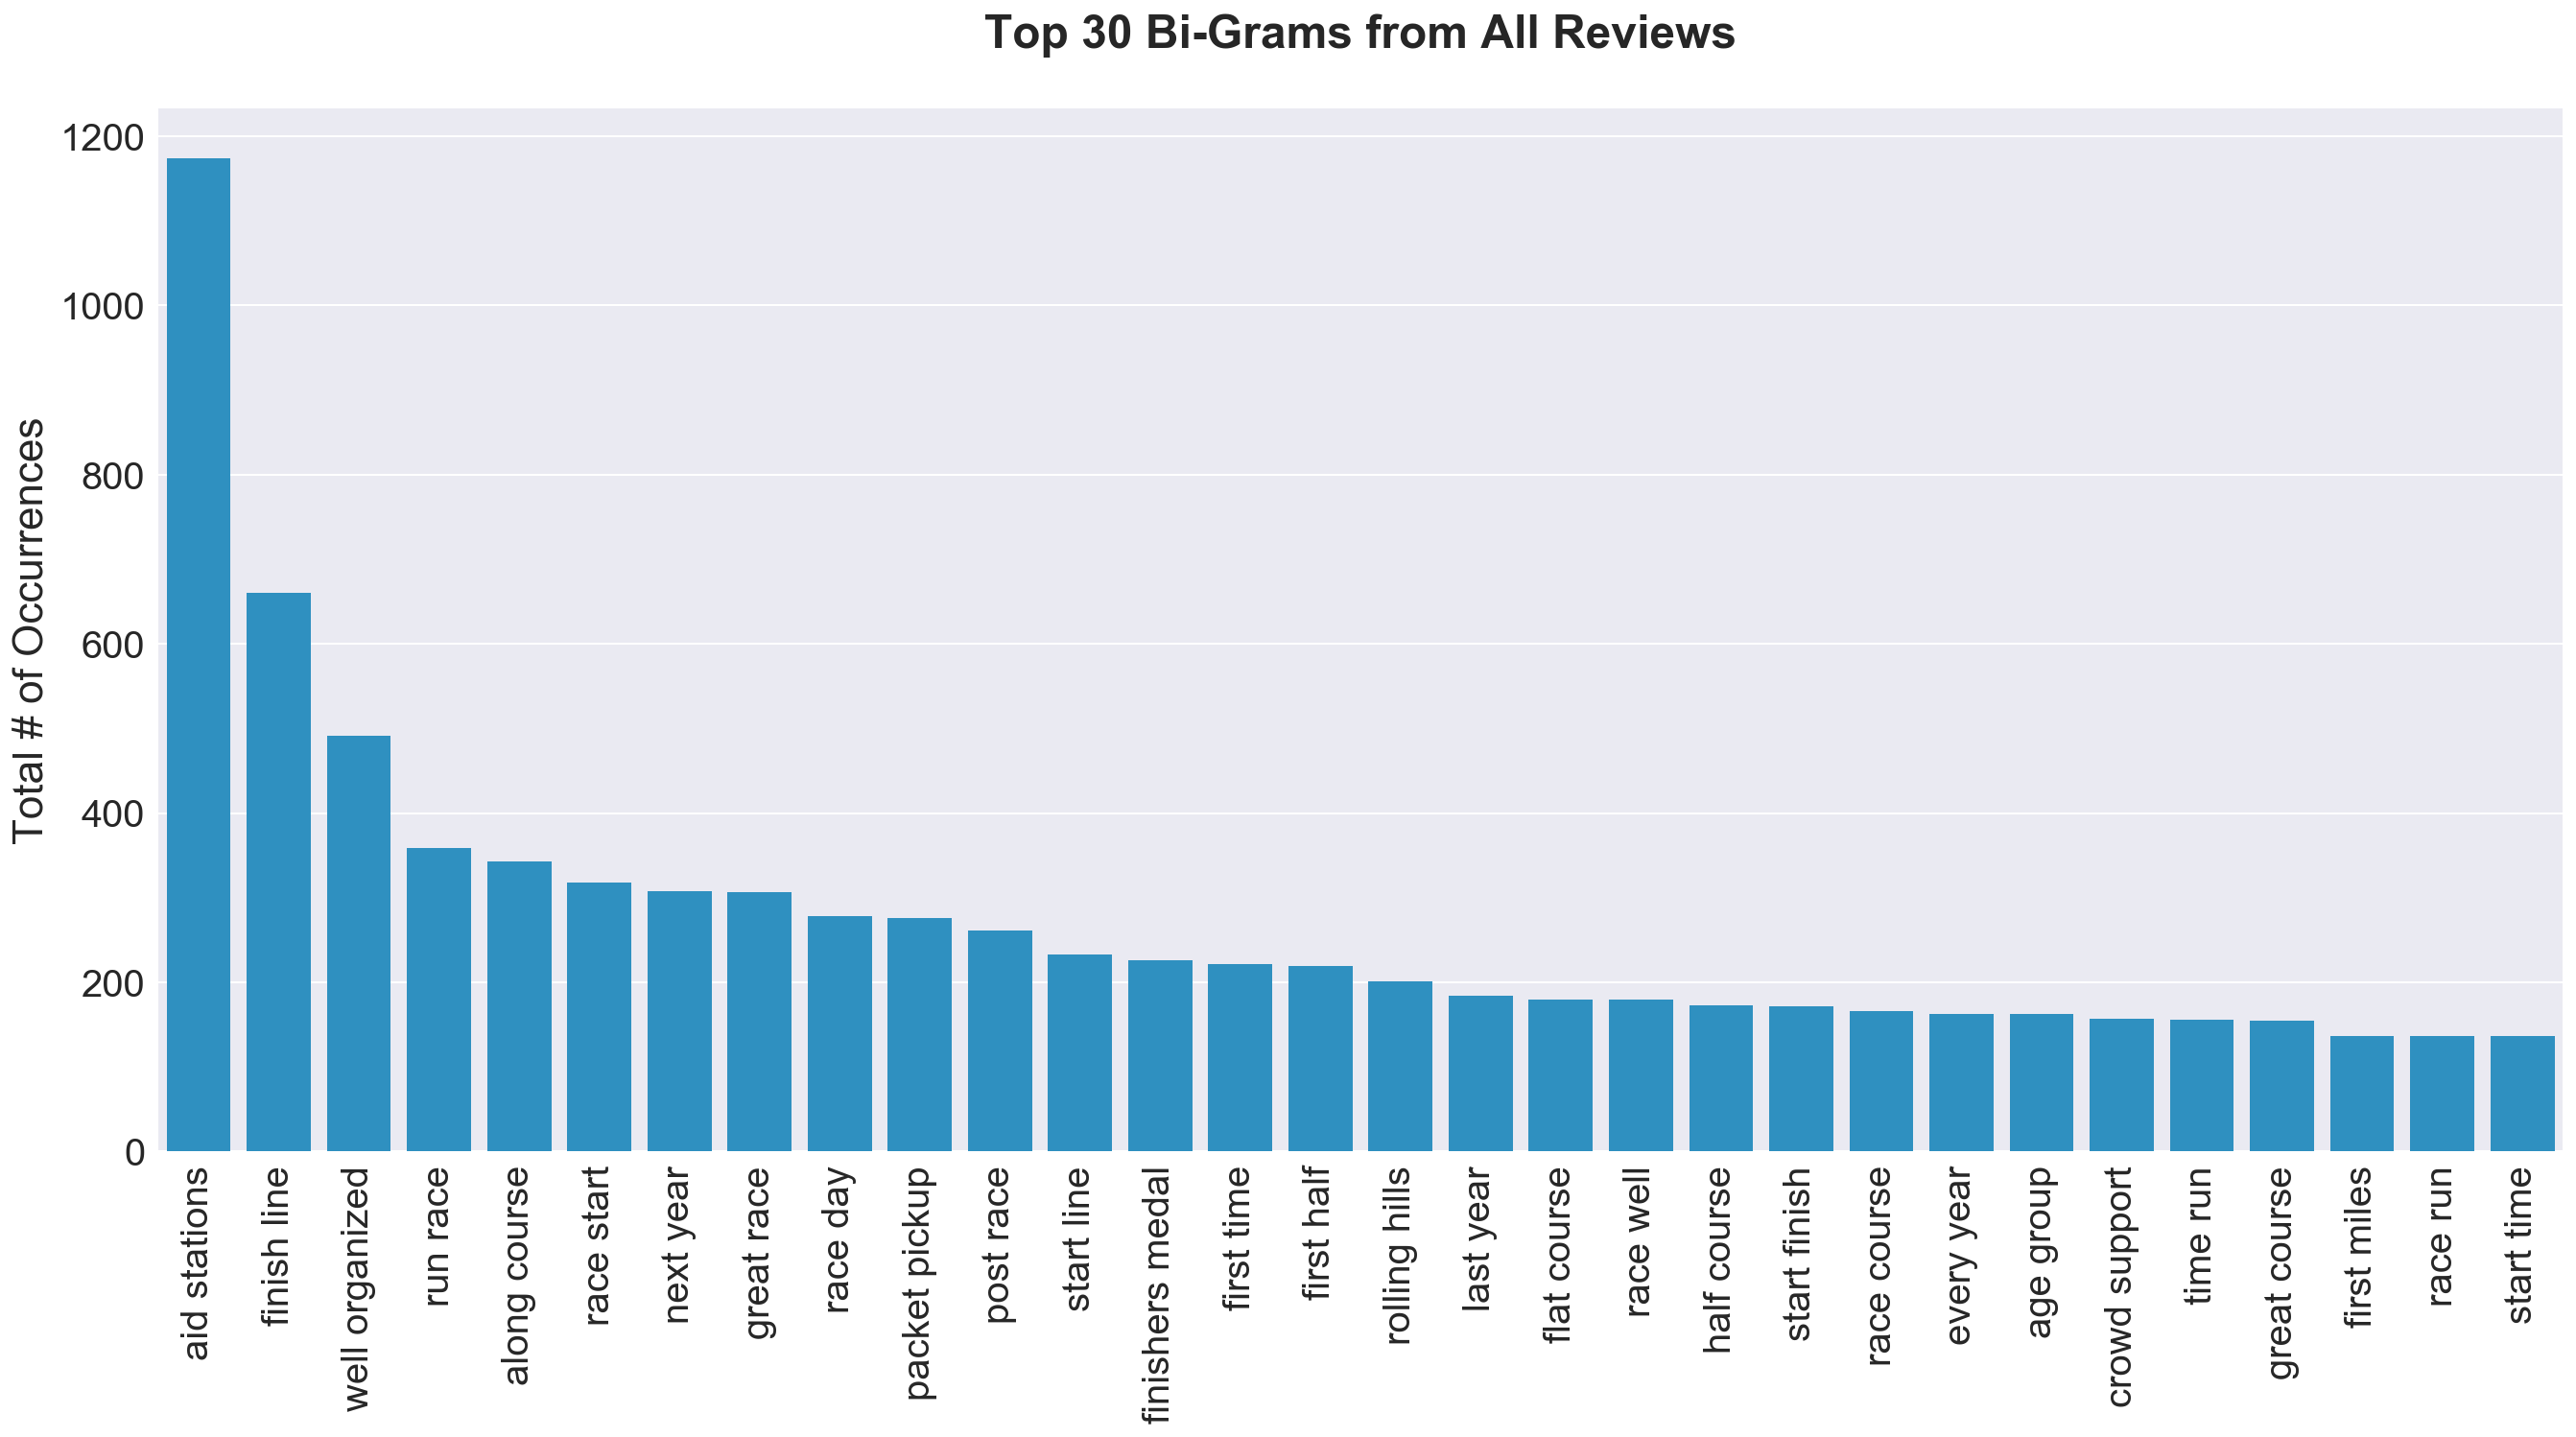

In [129]:
review_vect_df_sum = review_vect_df.sum(axis=0)
review_vect_top30 = review_vect_df_sum.sort_values(ascending=False).head(30)
plt.figure(figsize=(20, 10))
sns.set(font_scale=2)
bigram_plot = sns.barplot(review_vect_top30.index, review_vect_top30.values, color='#1798D8')
bigram_plot.set_title("Top 30 Bi-Grams from All Reviews\n", fontsize=24, weight='bold')
bigram_plot.set_ylabel('Total # of Occurrences')
bigram_plot.set_xticklabels(labels=review_vect_top30.index, rotation=90, fontsize=20)
plt.savefig('./plots/bigram_counts_all.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True);

### Latent Dirichlet Allocation
Next is the key step - assigning Topics to the reviews using Latent Dirichlet Allocation. After many iterations, 30 topics gave us the best results. We'll also use online learning with a decay of 0.8 and 100 max iterations. After running the LDA, we can look at the top 20 terms for the 30 topics. We can also use __describe__ to provide a summary of the probabilities for each topic.

In [130]:
lda = LatentDirichletAllocation(n_components=30, random_state=111, learning_method='online',
                                learning_decay=0.8, learning_offset=10, max_iter=100)
review_vect_lda = lda.fit(review_vect_df)

In [131]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d:\n" % topic_idx
        message += "\n".join([feature_names[i] + ' (' + str(round(topic[i],0)) + ')'
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()

print_top_words(lda, review_vect_names, 20)

Topic #0:
finish area (129.0)
course great (111.0)
course description (57.0)
opinion race (51.0)
organization production (51.0)
results opinion (49.0)
trail runs (48.0)
swag goodies (48.0)
great scenery (35.0)
great food (32.0)
friendly volunteers (32.0)
amazing race (31.0)
first ever (30.0)
little bit (29.0)
water stations (29.0)
swag bag (28.0)
nice flat (28.0)
awesome volunteers (25.0)
half full (22.0)
registration fee (3.0)

Topic #1:
loved race (61.0)
much fun (57.0)
great experience (52.0)
throughout course (50.0)
dont get (46.0)
love run (46.0)
come back (46.0)
definitely recommend (43.0)
ever run (39.0)
throughout race (39.0)
race ever (34.0)
san diego (33.0)
along beach (32.0)
race ran (29.0)
start race (10.0)
many run (4.0)
dont know (3.0)
race course (0.0)
run along (0.0)
aid stations (0.0)

Topic #2:
rolling hills (201.0)
first miles (136.0)
fun race (95.0)
run run (75.0)
aid stations (67.0)
great run (49.0)
run around (44.0)
postrace party (43.0)
porta potties (40.0)
peopl

In [132]:
topic_columns = ['Topic_{}'.format(i) for i in range(lda.components_.shape[0])]
review_topics = pd.DataFrame(lda.transform(review_vect_df), columns=topic_columns)
review_topics.describe().T

,count,mean,std,min,25%,50%,75%,max
Topic_0,5057.0,0.024261,0.058684,0.000450,0.004167,0.006667,0.016667,0.879167
Topic_1,5057.0,0.024956,0.058883,0.000422,0.004167,0.006667,0.016667,0.516667
Topic_2,5057.0,0.038845,0.086983,0.000422,0.004762,0.008333,0.016667,0.806667
Topic_3,5057.0,0.036665,0.086461,0.000388,0.004762,0.008333,0.016667,0.838889
Topic_4,5057.0,0.027425,0.062174,0.000422,0.004762,0.006667,0.016667,0.677778
Topic_5,5057.0,0.044235,0.092391,0.000422,0.004762,0.008333,0.016667,0.848718
Topic_6,5057.0,0.030471,0.071244,0.000388,0.004167,0.006667,0.016667,0.758333
Topic_7,5057.0,0.044137,0.092679,0.000725,0.004762,0.008333,0.016667,0.865151
Topic_8,5057.0,0.021668,0.053925,0.000422,0.004167,0.006667,0.011111,0.758333
Topic_9,5057.0,0.027035,0.067802,0.000388,0.004167,0.006667,0.016667,0.677778


Next, we'll use __wordcloud__ to create wordcloud images for each of the topics so we can visualize the themes.

In [133]:
top_word_list = []
for topic_idx, topic in enumerate(lda.components_):
    word_dict = {}
    for i in topic.argsort()[:-50 - 1:-1]:
        underscored = review_vect_names[i].replace(' ','_')
        word_dict[underscored] = round(topic[i],0) 
    top_word_list.append(word_dict)

In [134]:
from wordcloud import WordCloud

for topic in range(len(top_word_list)):
    top_words = top_word_list[topic]
    top_words_list = ''
    for key, value in top_words.items():
        for i in range(int(value)):
            top_words_list += key + " "
    top_words_list

    wordcloud = WordCloud(background_color='#aaaaaa', width=1000, height=600, prefer_horizontal=0.7, 
                          colormap='magma', max_font_size=200, collocations=False).generate(top_words_list)
    plot_file = './Wordclouds/Wordcloud_Topic_' + str(topic) + '.png'
    fig, ax = plt.subplots( nrows=1, ncols=1 )
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    fig.savefig(plot_file, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close(fig)

### Matching Racers and Races
#### Racers
Now that we've trained the LDA, we can use it to assign topics at the racer and race levels. First, we need to roll-up the reviews into single bags of words for each racer and race.

We'll tackle the racers first:

In [135]:
racer_combined = {}
previous_racer = ''
for i in range(len(race_review_train)):
    current_racer = race_review_train.iloc[i]['racer_id']
    distance = race_review_train.iloc[i]['distance_trunc']
    text = race_review_train.iloc[i]['text']
    if (current_racer != previous_racer):
        # add previous racer to dictionary
        if i > 0:
            racer_combined[previous_racer] = {'racer_id': previous_racer, 'num_reviews': num_reviews, \
                                              'distances': distances, 'num_distances': len(distances), \
                                              'all_reviews': all_texts}
        # reset variables for new racer
        num_reviews = 1
        previous_racer = current_racer
        distances = [distance]
        all_texts = text
        if i == len(race_review_train) - 1:
            racer_combined[previous_racer] = {'racer_id': previous_racer, 'num_reviews': num_reviews, \
                                              'distances': distances, 'num_distances': len(distances), \
                                              'all_reviews': all_texts}
    else:
        num_reviews += 1
        if distance not in distances:
            distances.append(distance)
        all_texts += ' ' + text
        
racer_combined = pd.DataFrame.from_dict(racer_combined, orient='index')
racer_combined = racer_combined.reset_index(drop=True)
racer_combined.head()

,racer_id,num_reviews,distances,num_distances,all_reviews
0,16490derek,1,[Marathon ],1,Hamilton is an intimate race gathering with a...
1,18anjel,3,"[Half Marathon , 10K , 5K ]",3,The most standout amazing part of this race w...
2,1FlyMother,1,[Half Marathon ],1,Ive run this several times and Ill probably r...
3,1ladybugangel,1,[10K ],1,Medal is amazing aid stations stocked and ste...
4,428lyman,1,[Half Marathon ],1,Love Fargo Did my first full there in 2015 an...


In [136]:
racer_combined.shape

(1607, 5)

Now that we have the racers and their combined reviews, we need to convert their distances to dummies for later model use.

In [137]:
distance_dummies = pd.get_dummies(pd.DataFrame(racer_combined['distances'].tolist()).stack()).sum(level=0)
racer_combined = pd.merge(left=racer_combined, right=distance_dummies,
                      left_index=True, right_index=True, how='left')
racer_combined = racer_combined.drop('distances', axis=1)
racer_combined = racer_combined.fillna(0)
racer_combined.head()

,racer_id,num_reviews,num_distances,all_reviews,10 Miler,10K,12K,15K,25K,4 Miler,5 Miler,50 Miler,50K,5K,8K,Half Marathon,Half Marathon Relay,Marathon,Marathon Relay,Other
0,16490derek,1,1,Hamilton is an intimate race gathering with a...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,18anjel,3,3,The most standout amazing part of this race w...,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,1FlyMother,1,1,Ive run this several times and Ill probably r...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1ladybugangel,1,1,Medal is amazing aid stations stocked and ste...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,428lyman,1,1,Love Fargo Did my first full there in 2015 an...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


We can also summarize ratings at the racer level, since we have the values from the individual races.

In [138]:
racer_ratings_summary = race_review_train.groupby('racer_id').mean()
racer_ratings_summary = racer_ratings_summary.reset_index()
racer_combined = pd.merge(left=racer_combined, right=racer_ratings_summary, on='racer_id')
racer_combined.head()

,racer_id,num_reviews,num_distances,all_reviews,10 Miler,10K,12K,15K,25K,4 Miler,...,Half Marathon,Half Marathon Relay,Marathon,Marathon Relay,Other,diff_rating,overall_rating,prod_rating,scenery_rating,swag_rating
0,16490derek,1,1,Hamilton is an intimate race gathering with a...,0,0,0,0,0,0,...,0,0,1,0,0,4.000000,5.0,5.0,4.000000,3.000000
1,18anjel,3,3,The most standout amazing part of this race w...,0,1,0,0,0,0,...,1,0,0,0,0,1.666667,4.0,4.0,3.666667,2.666667
2,1FlyMother,1,1,Ive run this several times and Ill probably r...,0,0,0,0,0,0,...,1,0,0,0,0,1.000000,4.0,3.0,5.000000,1.000000
3,1ladybugangel,1,1,Medal is amazing aid stations stocked and ste...,0,1,0,0,0,0,...,0,0,0,0,0,4.000000,5.0,5.0,5.000000,4.000000
4,428lyman,1,1,Love Fargo Did my first full there in 2015 an...,0,0,0,0,0,0,...,1,0,0,0,0,3.000000,5.0,5.0,5.000000,5.000000


Finally, we can bring in affiliations for later profiling.

In [139]:
affiliations = ['100 Half Marathons Club', '50 states aspirant/finisher', 'Boston Marathon finisher', \
                'Half Fanatic', 'Ironman', 'Marathon Maniac', 'Seven Continents Club']
all_racers[affiliations].sum()

100 Half Marathons Club         40.0
50 states aspirant/finisher    178.0
Boston Marathon finisher       166.0
Half Fanatic                   223.0
Ironman                         67.0
Marathon Maniac                128.0
Seven Continents Club           39.0
dtype: float64

In [140]:
to_merge = affiliations + ['racer_id']
racer_combined = pd.merge(left=racer_combined, right=all_racers[to_merge], on='racer_id')
racer_combined.head()

,racer_id,num_reviews,num_distances,all_reviews,10 Miler,10K,12K,15K,25K,4 Miler,...,prod_rating,scenery_rating,swag_rating,100 Half Marathons Club,50 states aspirant/finisher,Boston Marathon finisher,Half Fanatic,Ironman,Marathon Maniac,Seven Continents Club
0,16490derek,1,1,Hamilton is an intimate race gathering with a...,0,0,0,0,0,0,...,5.0,4.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18anjel,3,3,The most standout amazing part of this race w...,0,1,0,0,0,0,...,4.0,3.666667,2.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1FlyMother,1,1,Ive run this several times and Ill probably r...,0,0,0,0,0,0,...,3.0,5.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1ladybugangel,1,1,Medal is amazing aid stations stocked and ste...,0,1,0,0,0,0,...,5.0,5.000000,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,428lyman,1,1,Love Fargo Did my first full there in 2015 an...,0,0,0,0,0,0,...,5.0,5.000000,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we can apply the LDA topics to the racers. Note that after we get counts from the Count Vectorizer, we need to divide them by the number of reviews. That's because the LDA model was trained on individual reviews, so the counts need to be PER REVIEW.

In [141]:
X = review_vect.transform(racer_combined['all_reviews'])
racer_combined_vect = pd.DataFrame(X.toarray(), columns=review_vect.get_feature_names())
num_reviews = racer_combined['num_reviews']
racer_combined_vect = racer_combined_vect.div(num_reviews, axis='index')
racer_topics = pd.DataFrame(lda.transform(racer_combined_vect), columns=topic_columns)
racer_topics.describe(percentiles=[.25, .5, .75, .9]).T

,count,mean,std,min,25%,50%,75%,90%,max
Topic_0,1607.0,0.024672,0.054354,0.000866,0.005128,0.008333,0.016667,0.056548,0.879167
Topic_1,1607.0,0.026380,0.051328,0.000980,0.005556,0.008333,0.016667,0.068174,0.516667
Topic_2,1607.0,0.033522,0.067160,0.000866,0.005556,0.008333,0.033333,0.093797,0.677778
Topic_3,1607.0,0.036749,0.078483,0.001075,0.005556,0.008333,0.028056,0.103333,0.838889
Topic_4,1607.0,0.025743,0.050850,0.001075,0.005556,0.008333,0.016667,0.064714,0.516667
Topic_5,1607.0,0.051019,0.090097,0.001075,0.005556,0.011111,0.049022,0.172222,0.848718
Topic_6,1607.0,0.031811,0.064505,0.000980,0.005556,0.008333,0.023548,0.088889,0.677778
Topic_7,1607.0,0.040241,0.080058,0.001111,0.005556,0.008333,0.033333,0.129167,0.806667
Topic_8,1607.0,0.022793,0.052418,0.000866,0.004970,0.008333,0.016667,0.042667,0.758333
Topic_9,1607.0,0.024243,0.054118,0.000980,0.005000,0.008333,0.016667,0.053236,0.516667


In [142]:
racer_with_topics = pd.concat([racer_combined.drop('all_reviews', axis=1), \
                               racer_topics[topic_columns]], axis=1)
racer_with_topics.head()

,racer_id,num_reviews,num_distances,10 Miler,10K,12K,15K,25K,4 Miler,5 Miler,...,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29
0,16490derek,1,1,0,0,0,0,0,0,0,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,18anjel,3,3,0,1,0,0,0,0,0,...,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,0.108572,0.005882,0.005882
2,1FlyMother,1,1,0,0,0,0,0,0,0,...,0.001515,0.001515,0.048722,0.001515,0.001515,0.530873,0.001515,0.091345,0.001515,0.001515
3,1ladybugangel,1,1,0,1,0,0,0,0,0,...,0.008333,0.008333,0.272771,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.258333
4,428lyman,1,1,0,0,0,0,0,0,0,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


In [143]:
racer_topic_pcts = []
for topic in topic_columns:
    count = racer_with_topics[racer_with_topics[topic] > 0.1]['racer_id'].count()
    racer_topic_pcts.append(count / len(racer_with_topics))
racer_topic_pcts = pd.DataFrame(racer_topic_pcts, index=topic_columns, columns=['topic_pct'])
racer_topic_pcts

,topic_pct
Topic_0,0.065339
Topic_1,0.073429
Topic_2,0.092719
Topic_3,0.102676
Topic_4,0.060983
Topic_5,0.162414
Topic_6,0.085252
Topic_7,0.127567
Topic_8,0.050404
Topic_9,0.056005


#### Races
Now we need to run the same process to get topics at the race level. The first step here is re-sorting the review data by race before running it through the same combining algorithm we did for racers.

In [ ]:
race_review_sorted = race_review_train.sort_values('race_name').reset_index(drop=True)
race_review_sorted.head()

In [145]:
race_combined = {}
previous_race = ''
for i in range(len(race_review_sorted)):
    current_race = race_review_sorted.iloc[i]['race_name']
    distance = race_review_sorted.iloc[i]['distance_trunc']
    text = race_review_sorted.iloc[i]['text']
    if (current_race != previous_race):
        # add previous racer to dictionary
        if i > 0:
            race_combined[previous_race] = {'race_name': previous_race, 'num_reviews': num_reviews, \
                                            'distances': distances, 'num_distances': len(distances), \
                                            'all_reviews': all_texts}
        # reset variables for new racer
        num_reviews = 1
        previous_race = current_race
        distances = [distance]
        all_texts = text
        if i == len(race_review_sorted) - 1:
            race_combined[previous_race] = {'race_name': previous_race, 'num_reviews': num_reviews, \
                                            'distances': distances, 'num_distances': len(distances), \
                                            'all_reviews': all_texts}
    else:
        num_reviews += 1
        if distance not in distances:
            distances.append(distance)
        all_texts += ' ' + text
        
race_combined = pd.DataFrame.from_dict(race_combined, orient='index')
race_combined = race_combined.reset_index(drop=True)
race_combined.head()

,race_name,num_reviews,distances,num_distances,all_reviews
0,10K on the Bay,3,"[10K , 5K ]",2,The Hayward 10k on the Bay and 5k is so sceni...
1,20 Mile Drop & 10 Mile Drop,1,[10 Miler ],1,This race is well organized by Geoff and his ...
2,3M Half Marathon,2,[Half Marathon ],1,Well organized race the course is all downhil...
3,5-3-1 Run! July 4th Woodland Schools Foundatio...,1,[5 Miler ],1,Course Description The course was almost lite...
4,5K Chilly Chili Race,1,[5K ],1,Here in Chicago its tough to find races once ...


In [146]:
race_combined.shape

(1768, 5)

Once again, we need create distance features and add ratings data.

In [147]:
distance_dummies = pd.get_dummies(pd.DataFrame(race_combined['distances'].tolist()).stack()).sum(level=0)
race_combined = pd.merge(left=race_combined, right=distance_dummies,
                         left_index=True, right_index=True, how='left')
race_combined = race_combined.drop('distances', axis=1)
race_combined = race_combined.fillna(0)
race_combined.head()

,race_name,num_reviews,num_distances,all_reviews,10 Miler,10K,12K,15K,25K,4 Miler,5 Miler,50 Miler,50K,5K,8K,Half Marathon,Half Marathon Relay,Marathon,Marathon Relay,Other
0,10K on the Bay,3,2,The Hayward 10k on the Bay and 5k is so sceni...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,20 Mile Drop & 10 Mile Drop,1,1,This race is well organized by Geoff and his ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3M Half Marathon,2,1,Well organized race the course is all downhil...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,5-3-1 Run! July 4th Woodland Schools Foundatio...,1,1,Course Description The course was almost lite...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,5K Chilly Chili Race,1,1,Here in Chicago its tough to find races once ...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [148]:
race_ratings_summary = race_review_train.groupby('race_name').mean()
race_ratings_summary = race_ratings_summary.reset_index()
race_combined = pd.merge(left=race_combined, right=race_ratings_summary, on='race_name')
race_combined.head()

,race_name,num_reviews,num_distances,all_reviews,10 Miler,10K,12K,15K,25K,4 Miler,...,Half Marathon,Half Marathon Relay,Marathon,Marathon Relay,Other,diff_rating,overall_rating,prod_rating,scenery_rating,swag_rating
0,10K on the Bay,3,2,The Hayward 10k on the Bay and 5k is so sceni...,0,1,0,0,0,0,...,0,0,0,0,0,1.333333,3.666667,4.333333,3.333333,2.666667
1,20 Mile Drop & 10 Mile Drop,1,1,This race is well organized by Geoff and his ...,1,0,0,0,0,0,...,0,0,0,0,0,2.000000,5.000000,5.000000,4.000000,5.000000
2,3M Half Marathon,2,1,Well organized race the course is all downhil...,0,0,0,0,0,0,...,1,0,0,0,0,1.500000,4.500000,4.500000,3.500000,4.500000
3,5-3-1 Run! July 4th Woodland Schools Foundatio...,1,1,Course Description The course was almost lite...,0,0,0,0,0,0,...,0,0,0,0,0,2.000000,4.000000,3.000000,3.000000,4.000000
4,5K Chilly Chili Race,1,1,Here in Chicago its tough to find races once ...,0,0,0,0,0,0,...,0,0,0,0,0,1.000000,3.000000,4.000000,3.000000,2.000000


And then we can apply the Count Vectorizer and LDA trained on the full set of training reviews. As we did with the racers, we need to divide counts by the number of reviews before applying LDA.

In [149]:
X = review_vect.transform(race_combined['all_reviews'])
race_combined_vect = pd.DataFrame(X.toarray(), columns=review_vect_names)
num_reviews = race_combined['num_reviews']
race_combined_vect = race_combined_vect.div(num_reviews, axis='index')
race_topics = pd.DataFrame(lda.transform(race_combined_vect), columns=topic_columns)
race_topics.describe().T

,count,mean,std,min,25%,50%,75%,max
Topic_0,1768.0,0.024347,0.051241,0.000741,0.004762,0.008333,0.016667,0.677778
Topic_1,1768.0,0.021742,0.046017,0.000680,0.004762,0.007407,0.016667,0.516667
Topic_2,1768.0,0.038195,0.073071,0.000680,0.005128,0.008333,0.033333,0.677778
Topic_3,1768.0,0.035044,0.068995,0.000388,0.004762,0.008333,0.031856,0.606667
Topic_4,1768.0,0.027575,0.054530,0.000709,0.004762,0.008333,0.022795,0.516667
Topic_5,1768.0,0.042019,0.075320,0.000709,0.005128,0.009091,0.035748,0.806667
Topic_6,1768.0,0.029899,0.063336,0.000388,0.004762,0.008333,0.016667,0.516667
Topic_7,1768.0,0.048316,0.089066,0.001075,0.005252,0.008333,0.033333,0.677778
Topic_8,1768.0,0.021542,0.047900,0.000741,0.004762,0.007407,0.016667,0.516667
Topic_9,1768.0,0.026226,0.056776,0.000388,0.004762,0.008333,0.016667,0.677778


In [150]:
race_with_topics = pd.concat([race_combined.drop('all_reviews', axis=1), \
                              race_topics[topic_columns]], axis=1)
race_with_topics.head()

,race_name,num_reviews,num_distances,10 Miler,10K,12K,15K,25K,4 Miler,5 Miler,...,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29
0,10K on the Bay,3,2,0,1,0,0,0,0,0,...,0.009091,0.009091,0.009091,0.009091,0.009091,0.009091,0.009091,0.009091,0.009091,0.009091
1,20 Mile Drop & 10 Mile Drop,1,1,1,0,0,0,0,0,0,...,0.006667,0.406667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667
2,3M Half Marathon,2,1,0,0,0,0,0,0,0,...,0.004762,0.004762,0.004762,0.004762,0.076190,0.004762,0.147191,0.004762,0.004762,0.076190
3,5-3-1 Run! July 4th Woodland Schools Foundatio...,1,1,0,0,0,0,0,0,1,...,0.000926,0.077561,0.000926,0.000926,0.000926,0.000926,0.000926,0.067406,0.000926,0.080867
4,5K Chilly Chili Race,1,1,0,0,0,0,0,0,0,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.508333,0.008333,0.008333,0.008333,0.008333


In [151]:
race_topic_pcts = []
for topic in topic_columns:
    count = race_with_topics[race_with_topics[topic] > 0.1]['race_name'].count()
    race_topic_pcts.append(count / len(race_with_topics))
race_topic_pcts = pd.DataFrame(race_topic_pcts, index=topic_columns, columns=['topic_pct'])
race_topic_pcts

,topic_pct
Topic_0,0.060520
Topic_1,0.050905
Topic_2,0.115385
Topic_3,0.096154
Topic_4,0.067873
Topic_5,0.131787
Topic_6,0.076357
Topic_7,0.167421
Topic_8,0.042421
Topic_9,0.069005


Now that we have topics assigned to racers and races, we can compare the distributions. We'll use the percent that got a probability of 10% or more for each topic.

''

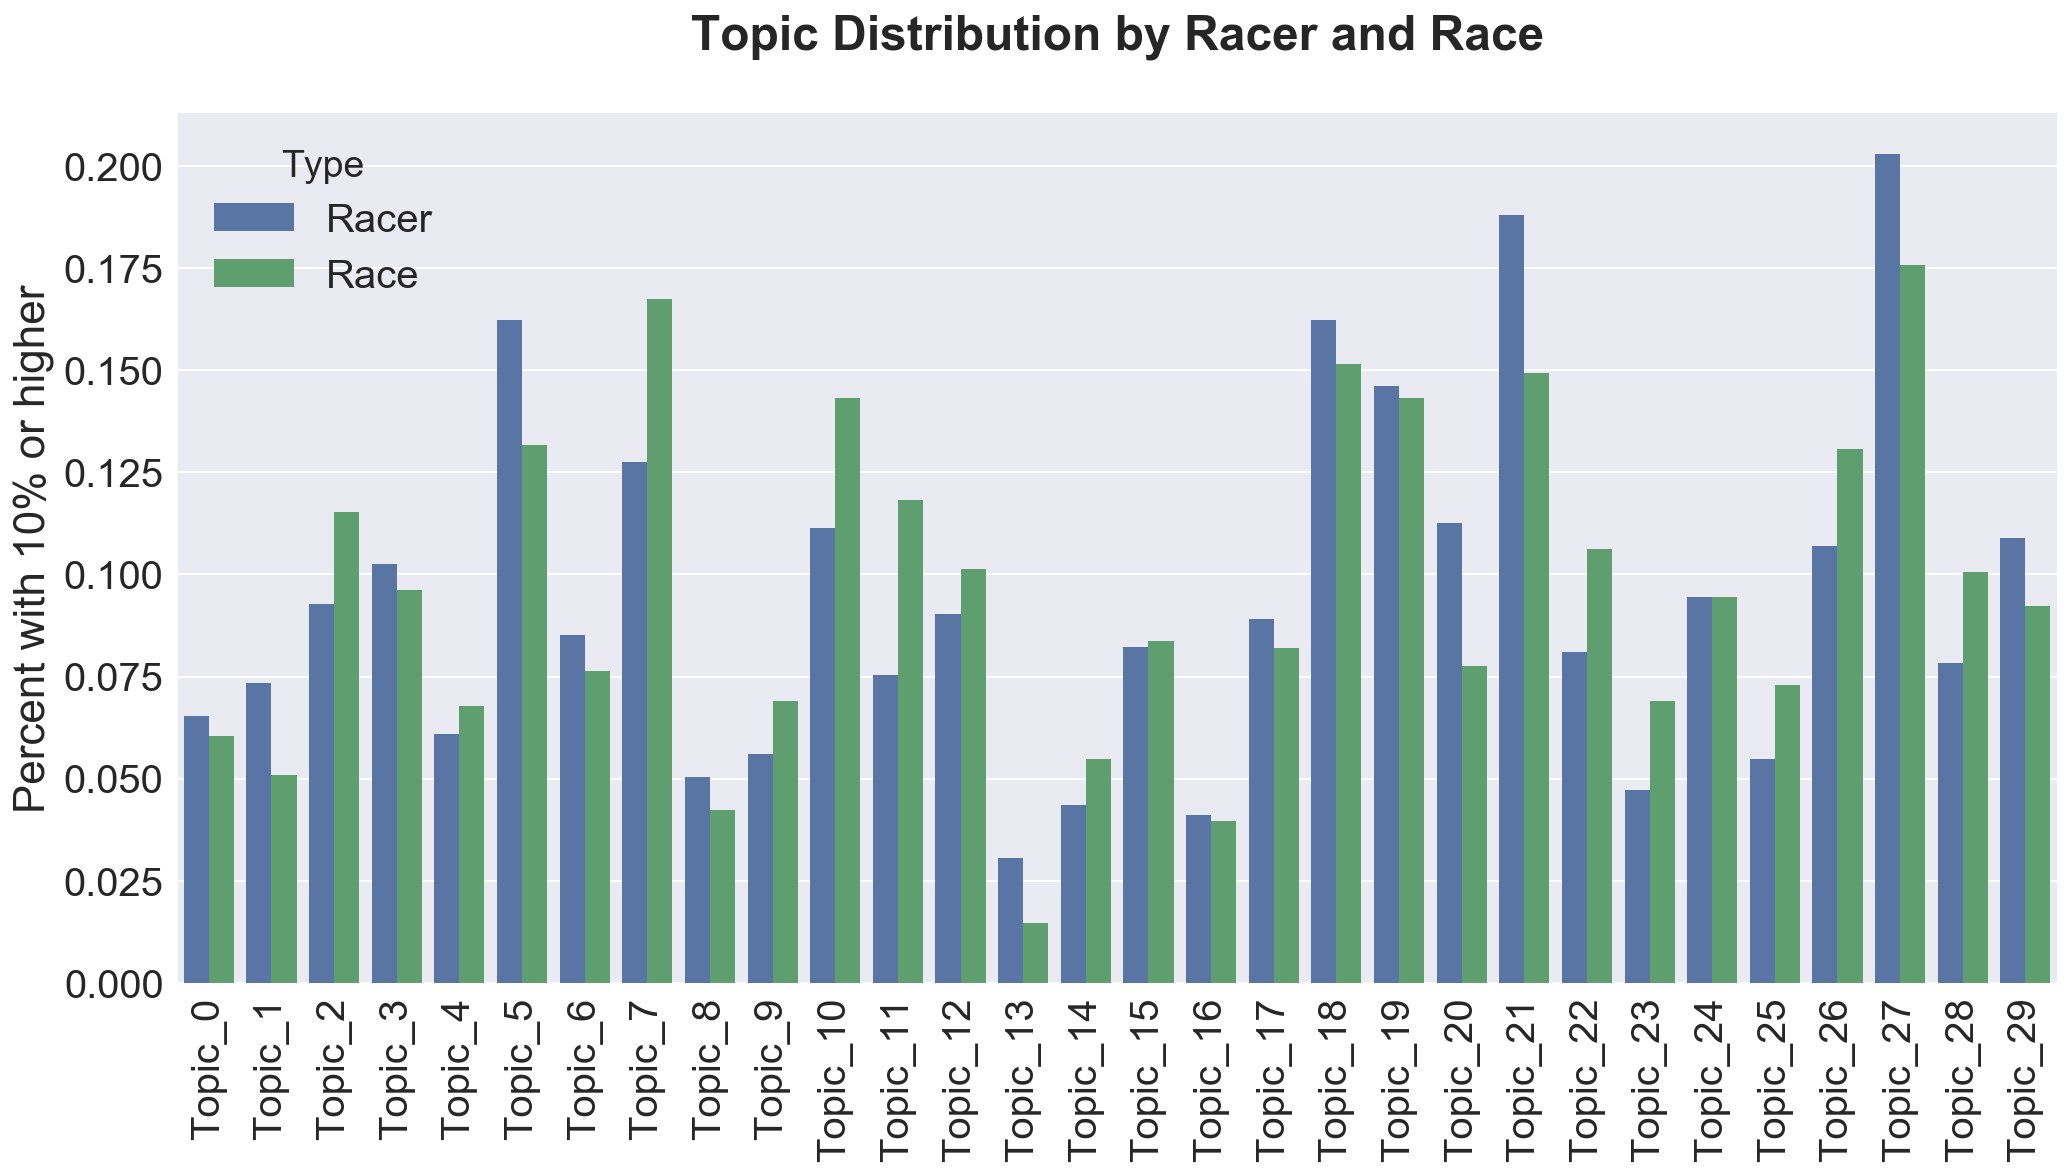

In [152]:
racer_topic_pcts['Type'] = 'Racer'
race_topic_pcts['Type'] = 'Race'
topic_pcts = pd.concat([racer_topic_pcts, race_topic_pcts], axis=0)
plt.figure(figsize=(15, 8))
sns.set(font_scale=2)
topic_plot = sns.barplot(x=topic_pcts.index, y=topic_pcts['topic_pct'], hue=topic_pcts['Type'])
topic_plot.set_title("Topic Distribution by Racer and Race\n", fontsize=24, weight='bold')
topic_plot.set_ylabel('Percent with 10% or higher')
topic_plot.set_xticklabels(labels=topic_columns, rotation=90, fontsize=20)
plt.savefig('./plots/topic_dist.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
;

Not surprisingly the distributions are pretty similar (they were built on the same data), but there's definitely some variation drive by the roll-ups at racer and race level.

#### Matching
Now we need to match races to individual racers. Each racer and race has been assigned 30 probabilities, one for each of the LDA topics. We can calculate the Euclidean Distance between each racer and each race  for these 30 probabilities and then rank order the distances to determine which races are most highly aligned with each racer. We'll look at the top race and the top 5 to see how well we've matched.

In [153]:
ss=StandardScaler()

racers_for_scoring = racer_with_topics[topic_columns]
races_for_scoring = race_with_topics[topic_columns]

racers_scaled = ss.fit_transform(racers_for_scoring)
races_scaled = ss.fit_transform(races_for_scoring)

racers_scored = []
for i in range(len(racers_scaled)):
    racer_scored = []
    for j in range(len(races_scaled)):
        total_diff = 0.0
        for k in range(len(topic_columns)):
            total_diff += (float(racers_scaled[i, k]) - float(races_scaled[j, k]))**2
        racer_scored.append(np.sqrt(total_diff))
    racers_scored.append(racer_scored)

racers_scored_df = pd.DataFrame(racers_scored, 
                                index=racer_with_topics.index, columns=race_with_topics['race_name'])
racers_scored_df.head()

race_name,10K on the Bay,20 Mile Drop & 10 Mile Drop,3M Half Marathon,5-3-1 Run! July 4th Woodland Schools Foundation Run,5K Chilly Chili Race,6 Stones Run For Hope,7 Bridges Marathon & 4 Bridges Half Marathon,7 Mile Bridge Run,A Midsummer Night’s Run,A Run Through Redlands,...,ZombieRunner Quarry Lakes (Winter),ZombieRunner Vasona Lake Run,Zoom Ayala Cove Run,Zoom Point Pinole,Zoom Quarry Lakes (Summer),Zoom Turkey Trot,Zoom! Yah! Yah! Indoor Marathon,Zurich Marathon,Zydeco Marathon & Half Marathon,eDreams Barcelona Half Marathon
0,9.745096,6.068428,9.454107,8.969013,12.289357,10.321984,10.668473,10.816220,9.561637,10.288558,...,8.633174,10.131102,7.954058,9.480147,9.499510,10.669805,10.081490,11.556404,10.082499,9.326335
1,6.172558,9.478350,6.329935,6.539826,10.315238,7.503965,8.323398,5.338456,6.682568,6.309546,...,5.697365,6.240737,6.869312,6.744819,6.338398,8.421017,7.108941,8.739975,6.226999,5.799056
2,10.876845,12.846488,10.741165,10.707521,4.666738,11.731330,8.744213,11.886074,11.094630,9.163339,...,10.298632,11.294176,11.221272,11.157929,10.734984,12.642199,9.581659,12.847473,11.148193,8.950267
3,7.925118,10.127453,6.958874,6.682208,10.901742,7.351472,9.032715,9.206749,6.968853,8.577612,...,6.328723,8.387119,7.009180,7.358290,7.168060,9.412421,7.870757,10.068274,8.326460,6.527546
4,4.539991,8.003906,3.816909,4.623578,8.779006,5.762449,6.233161,6.668771,4.904100,5.537124,...,3.761572,5.399468,5.207273,4.766829,5.019052,7.363043,5.083295,7.580845,5.356862,3.752162


In [154]:
recommended_races = []
for i in range(len(racers_scored_df)):
    races = racers_scored_df.iloc[i][racers_scored_df.iloc[i].nsmallest(5).index].index
    recommended_races.append(races)
recommended_races = pd.DataFrame(recommended_races, columns=['Race1', 'Race2', 'Race3', 'Race4', 'Race5'])
recommended_races = pd.concat([racer_with_topics['racer_id'], recommended_races], axis=1)
recommended_races.head()

,racer_id,Race1,Race2,Race3,Race4,Race5
0,16490derek,Santa Hustle Galveston,Umstead 100 Mile Endurance Run,St Anthony’s Saints Run,Florida Skydive Ultra Run,Superhero 5K
1,18anjel,Fredericksburg Blue & Gray 1/2 Marathon,Los Vaqueros Tarantula Run Half Marathon/10K/5...,The Aloha Run – Long Beach,OC Marathon Running Festival,Santa Barbara Veterans Day Half Marathon
2,1FlyMother,Grateful Dad Half Marathon,Spitsbergen Marathon,Life Time Tempe Triathlon,Roller Coaster Race – Six Flags Discovery Kingdom,Harvest Half Marathon/5K – Brentwood Family YMCA
3,1ladybugangel,CrossBridge 5k/10k Pancake Run,Sage Rat Run – Dirty Rat Run,Santa Fe Thunder Half Marathon,Omaha Marathon,Margarita Madness 5K – Oklahoma City
4,428lyman,Ahmanson Trails 12K/6K,Angus Glen Spring Ten Miler,Apple Blossom Races,Auffahrtslauf St. Gallen,Bay of Fundy International Marathon


### Hit Rates
Because we didn't exclude races that the racer already reviewed, we can calculate a Hit Rate to see how often we've recommended a race that the racer has already run. This provides some indication that we've done a good job with our matching. We can also look at the average rating for the recommended races to make sure we're not recommending bad options.

In [229]:
melted_races = pd.melt(recommended_races, id_vars=['racer_id'])
hits_top1 = pd.merge(left=melted_races[melted_races['variable'] == 'Race1'], right=race_review_train, 
                     left_on=['racer_id', 'value'], right_on=['racer_id', 'race_name'])
hits_top5 = pd.merge(left=melted_races, right=race_review_train, 
                     left_on=['racer_id', 'value'], right_on=['racer_id', 'race_name'])
hits1 = len(hits_top1['racer_id'].unique())
hits5 = len(hits_top5['racer_id'].unique())

print('Hits for Top Race:', hits1)
print('Hit Rate for Top Race: ', round(100*hits1/len(racer_with_topics), 1), '%', sep='')
print('Hits for Top 5 Races:', hits5)
print('Hit Rate for Top 5 Races: ', round(100*hits5/len(racer_with_topics), 1), '%', sep='')

Hits for Top Race: 182
Hit Rate for Top Race: 11.3%
Hits for Top 5 Races: 358
Hit Rate for Top 5 Races: 22.3%


In [230]:
hits_top1['overall_rating'].describe().T

count    182.000000
mean       4.274725
std        0.958428
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: overall_rating, dtype: float64

In [231]:
hits_top5['overall_rating'].describe().T

count    399.000000
mean       4.288221
std        0.953511
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: overall_rating, dtype: float64

In [232]:
race_with_topics['overall_rating'].describe().T

count    1768.000000
mean        4.041602
std         0.828786
min         1.000000
25%         4.000000
50%         4.000000
75%         4.727273
max         5.000000
Name: overall_rating, dtype: float64

### Validation
Next, we need to run the matching proces for the 20% of racers we did not include in the training, to see if we've found good matches for them.

In [159]:
racer_combined_test = {}
previous_racer = ''
for i in range(len(race_review_test)):
    current_racer = race_review_test.iloc[i]['racer_id']
    distance = race_review_test.iloc[i]['distance_trunc']
    text = race_review_test.iloc[i]['text']
    if (current_racer != previous_racer):
        # add previous racer to dictionary
        if i > 0:
            racer_combined_test[previous_racer] = {'racer_id': previous_racer, 'num_reviews': num_reviews, \
                                              'distances': distances, 'num_distances': len(distances), \
                                              'all_reviews': all_texts}
        # reset variables for new racer
        num_reviews = 1
        previous_racer = current_racer
        distances = [distance]
        all_texts = text
        if i == len(race_review_test) - 1:
            racer_combined_test[previous_racer] = {'racer_id': previous_racer, 'num_reviews': num_reviews, \
                                              'distances': distances, 'num_distances': len(distances), \
                                              'all_reviews': all_texts}
    else:
        num_reviews += 1
        if distance not in distances:
            distances.append(distance)
        all_texts += ' ' + text
        
racer_combined_test = pd.DataFrame.from_dict(racer_combined_test, orient='index')
racer_combined_test = racer_combined_test.reset_index(drop=True)
racer_combined_test.head()

,racer_id,num_reviews,distances,num_distances,all_reviews
0,090775candice,2,"[5K , Half Marathon ]",2,Have to do it again next year My daughter and...
1,2tallfritz,10,"[Marathon , 50K ]",2,Great race but very technical with lots of ro...
2,42kStraley,7,"[25K , Marathon ]",2,Bummed out because Mother Nature iced us out ...
3,Anniebananie320,1,[Marathon ],1,I used to live in San Francisco and one of th...
4,Bigguysawd,1,[Half Marathon ],1,Medals were awesome Course relatively easy Gr...


In [160]:
distance_dummies = pd.get_dummies(pd.DataFrame(racer_combined_test['distances'].tolist()).stack()).sum(level=0)
racer_combined_test = pd.merge(left=racer_combined_test, right=distance_dummies,
                      left_index=True, right_index=True, how='left')
racer_combined_test = racer_combined_test.drop('distances', axis=1)
racer_combined_test = racer_combined_test.fillna(0)
racer_combined_test.head()

,racer_id,num_reviews,num_distances,all_reviews,10 Miler,10K,12K,15K,25K,4 Miler,5 Miler,50 Miler,50K,5K,8K,Half Marathon,Half Marathon Relay,Marathon,Marathon Relay,Other
0,090775candice,2,2,Have to do it again next year My daughter and...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,2tallfritz,10,2,Great race but very technical with lots of ro...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,42kStraley,7,2,Bummed out because Mother Nature iced us out ...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,Anniebananie320,1,1,I used to live in San Francisco and one of th...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Bigguysawd,1,1,Medals were awesome Course relatively easy Gr...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [161]:
racer_ratings_summary = race_review_test.groupby('racer_id').mean()
racer_ratings_summary = racer_ratings_summary.reset_index()
racer_combined_test = pd.merge(left=racer_combined_test, right=racer_ratings_summary, on='racer_id')
racer_combined_test.head()

,racer_id,num_reviews,num_distances,all_reviews,10 Miler,10K,12K,15K,25K,4 Miler,...,Half Marathon,Half Marathon Relay,Marathon,Marathon Relay,Other,diff_rating,overall_rating,prod_rating,scenery_rating,swag_rating
0,090775candice,2,2,Have to do it again next year My daughter and...,0,0,0,0,0,0,...,1,0,0,0,0,4.000000,4.5,4.500000,4.500000,4.5
1,2tallfritz,10,2,Great race but very technical with lots of ro...,0,0,0,0,0,0,...,0,0,1,0,0,3.600000,4.0,4.500000,3.600000,3.6
2,42kStraley,7,2,Bummed out because Mother Nature iced us out ...,0,0,0,0,1,0,...,0,0,1,0,0,2.428571,4.0,4.285714,3.428571,4.0
3,Anniebananie320,1,1,I used to live in San Francisco and one of th...,0,0,0,0,0,0,...,0,0,1,0,0,4.000000,5.0,5.000000,5.000000,5.0
4,Bigguysawd,1,1,Medals were awesome Course relatively easy Gr...,0,0,0,0,0,0,...,1,0,0,0,0,2.000000,4.0,4.000000,5.000000,4.0


In [162]:
to_merge = affiliations + ['racer_id']
racer_combined_test = pd.merge(left=racer_combined_test, right=all_racers[to_merge], on='racer_id')
racer_combined_test.head()

,racer_id,num_reviews,num_distances,all_reviews,10 Miler,10K,12K,15K,25K,4 Miler,...,prod_rating,scenery_rating,swag_rating,100 Half Marathons Club,50 states aspirant/finisher,Boston Marathon finisher,Half Fanatic,Ironman,Marathon Maniac,Seven Continents Club
0,090775candice,2,2,Have to do it again next year My daughter and...,0,0,0,0,0,0,...,4.500000,4.500000,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2tallfritz,10,2,Great race but very technical with lots of ro...,0,0,0,0,0,0,...,4.500000,3.600000,3.6,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,42kStraley,7,2,Bummed out because Mother Nature iced us out ...,0,0,0,0,1,0,...,4.285714,3.428571,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Anniebananie320,1,1,I used to live in San Francisco and one of th...,0,0,0,0,0,0,...,5.000000,5.000000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bigguysawd,1,1,Medals were awesome Course relatively easy Gr...,0,0,0,0,0,0,...,4.000000,5.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
X = review_vect.transform(racer_combined_test['all_reviews'])
racer_combined_test_vect = pd.DataFrame(X.toarray(), columns=review_vect.get_feature_names())
num_reviews = racer_combined_test['num_reviews']
racer_combined_test_vect = racer_combined_test_vect.div(num_reviews, axis='index')
racer_topics_test = pd.DataFrame(lda.transform(racer_combined_test_vect), columns=topic_columns)
racer_topics_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Topic_0,401.0,0.025109,0.049805,0.001333,0.005556,0.008333,0.016667,0.516667
Topic_1,401.0,0.027068,0.058224,0.001852,0.005556,0.008333,0.016667,0.508333
Topic_2,401.0,0.038839,0.070492,0.001852,0.006061,0.011111,0.033333,0.516667
Topic_3,401.0,0.040761,0.076194,0.000939,0.006061,0.011111,0.033333,0.516667
Topic_4,401.0,0.028135,0.058773,0.001333,0.005556,0.009524,0.018153,0.516667
Topic_5,401.0,0.056671,0.094924,0.001333,0.006667,0.016667,0.059040,0.576190
Topic_6,401.0,0.031950,0.070162,0.000939,0.005556,0.009524,0.020833,0.758333
Topic_7,401.0,0.035510,0.076367,0.001852,0.005556,0.008829,0.016667,0.516667
Topic_8,401.0,0.020101,0.044557,0.001333,0.005263,0.008333,0.016667,0.516667
Topic_9,401.0,0.020054,0.042579,0.000939,0.005128,0.008333,0.016667,0.516667


In [164]:
racer_with_topics_test = pd.concat([racer_combined_test.drop('all_reviews', axis=1), \
                                    racer_topics_test[topic_columns]], axis=1)
racer_with_topics_test.head()

,racer_id,num_reviews,num_distances,10 Miler,10K,12K,15K,25K,4 Miler,5 Miler,...,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29
0,090775candice,2,2,0,0,0,0,0,0,0,...,0.009524,0.009524,0.009524,0.009524,0.152381,0.152381,0.009524,0.152381,0.009524,0.152381
1,2tallfritz,10,2,0,0,0,0,0,0,0,...,0.081761,0.006289,0.006289,0.006289,0.045191,0.006289,0.025193,0.151866,0.006289,0.025157
2,42kStraley,7,2,0,0,0,0,1,0,0,...,0.074444,0.007778,0.007778,0.041111,0.041111,0.104727,0.103667,0.007778,0.139282,0.007778
3,Anniebananie320,1,1,0,0,0,0,0,0,0,...,0.006667,0.006667,0.006667,0.206667,0.006667,0.006667,0.006667,0.006667,0.206667,0.206667
4,Bigguysawd,1,1,0,0,0,0,0,0,0,...,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667


In [165]:
racers_for_scoring = racer_with_topics_test[topic_columns]
races_for_scoring = race_with_topics[topic_columns]

racers_scaled = ss.fit_transform(racers_for_scoring)
races_scaled = ss.fit_transform(races_for_scoring)

racers_scored = []
for i in range(len(racers_scaled)):
    racer_scored = []
    for j in range(len(races_scaled)):
        total_diff = 0.0
        for k in range(len(topic_columns)):
            total_diff += (float(racers_scaled[i, k]) - float(races_scaled[j, k])) * \
                          (float(racers_scaled[i, k]) - float(races_scaled[j, k]))
        racer_scored.append(np.sqrt(total_diff))
    racers_scored.append(racer_scored)

racers_scored_test2 = pd.DataFrame(racers_scored, 
                                  index=racer_with_topics_test.index, columns=race_with_topics['race_name'])
racers_scored_test2.head()

race_name,10K on the Bay,20 Mile Drop & 10 Mile Drop,3M Half Marathon,5-3-1 Run! July 4th Woodland Schools Foundation Run,5K Chilly Chili Race,6 Stones Run For Hope,7 Bridges Marathon & 4 Bridges Half Marathon,7 Mile Bridge Run,A Midsummer Night’s Run,A Run Through Redlands,...,ZombieRunner Quarry Lakes (Winter),ZombieRunner Vasona Lake Run,Zoom Ayala Cove Run,Zoom Point Pinole,Zoom Quarry Lakes (Summer),Zoom Turkey Trot,Zoom! Yah! Yah! Indoor Marathon,Zurich Marathon,Zydeco Marathon & Half Marathon,eDreams Barcelona Half Marathon
0,6.344816,9.143552,5.432393,5.838462,8.011291,5.268541,6.962217,8.135486,6.371013,6.211065,...,5.783137,7.220881,6.719898,6.256152,6.770731,8.710363,6.468024,9.097934,7.150029,4.286585
1,5.453788,8.594763,4.473776,3.932573,9.523902,5.341208,6.606620,7.616211,5.819312,6.412810,...,3.978846,5.920980,5.519437,6.026701,4.670226,6.731158,5.576014,7.889342,5.577615,4.650150
2,6.029675,8.868203,4.637890,6.055024,8.435182,6.442711,6.093144,6.983478,6.048905,5.381766,...,4.685558,6.405276,5.540488,5.530435,6.170375,8.322153,5.654070,7.996562,5.169515,4.142993
3,7.993486,10.164697,6.900136,7.389918,10.996520,7.733637,8.127185,7.832038,7.054298,8.139873,...,7.332475,8.511360,8.152959,5.032230,7.972946,9.744389,7.437965,9.025052,6.815087,5.600484
4,8.571716,10.687872,8.249581,8.576327,11.451223,9.241672,9.631655,9.797706,7.914813,9.178216,...,7.356271,9.036052,4.290717,7.860160,8.820907,10.366341,8.932115,10.564434,9.006821,8.130890


In [166]:
recommended_races_validate = []
for i in range(len(racers_scored_test2)):
    races = racers_scored_test2.iloc[i][racers_scored_test2.iloc[i].nsmallest(5).index].index
    recommended_races_validate.append(races)
recommended_races_validate = pd.DataFrame(recommended_races_validate, columns=['Race1', 'Race2', 'Race3', 'Race4', 'Race5'])
recommended_races_validate = pd.concat([racer_with_topics_test['racer_id'], recommended_races_validate], axis=1)
recommended_races_validate.head()

,racer_id,Race1,Race2,Race3,Race4,Race5
0,090775candice,Thelma & Louise Half Marathon,Star Wars Half Marathon – The Light Side,Woodrow Wilson Bridge Half Marathon,Greenbrier Half Marathon,Santa Barbara Wine Country Half Marathon (Dest...
1,2tallfritz,Coyote Hills Half Marathon/10K/5K,Rock ‘n’ Roll New Orleans Marathon & 1/2 Marathon,Des Moines Marathon,Bank of America Chicago Marathon,Nitro Trail Half Marathon/10K/5K
2,42kStraley,Columbus Marathon & Half Marathon,Sioux Falls Marathon & Half Marathon,IPA 10K & Beer Mile Invitational,Surf City 10,"Race 13.1 Charleston, SC"
3,Anniebananie320,"Reindeer Run – Van Nuys, CA",Sioux Falls Marathon & Half Marathon,Krampus Cross Country 5K/10K,Golden Gate Half (fka US Half),Naples Daily News Half Marathon
4,Bigguysawd,Halloween Half Fort Worth,Chocolatathon,Cerros de Escazu Trail Run,Horseshoe Trail Run,The Disney Twilight Zone Tower of Terror 10 Mi...


In [225]:
melted_races = pd.melt(recommended_races_validate, id_vars=['racer_id'])
hits_valid_top1 = pd.merge(left=melted_races[melted_races['variable'] == 'Race1'], right=race_review_df, 
                           left_on=['racer_id', 'value'], right_on=['racer_id', 'race_name'])
hits_valid_top5 = pd.merge(left=melted_races, right=race_review_df, 
                           left_on=['racer_id', 'value'], right_on=['racer_id', 'race_name'])
hits_valid1 = len(hits_top1['racer_id'].unique())
hits_valid5 = len(hits_top5['racer_id'].unique())

print('Hits for Top Race:', hits_valid1)
print('Hit Rate for Top Race: ', round(100*hits_valid1/len(racer_with_topics_test), 1), '%', sep='')
print('Hits for Top 5 Races:', hits_valid5)
print('Hit Rate for Top 5 Races: ', round(100*hits_valid5/len(racer_with_topics_test), 1), '%', sep='')

Hits for Top Race: 9
Hit Rate for Top Race: 2.2%
Hits for Top 5 Races: 29
Hit Rate for Top 5 Races: 7.2%


In [227]:
hits_valid_top1['overall_rating'].describe().T

count    9.000000
mean     4.333333
std      0.707107
min      3.000000
25%      4.000000
50%      4.000000
75%      5.000000
max      5.000000
Name: overall_rating, dtype: float64

In [228]:
hits_valid_top5['overall_rating'].describe().T

count    41.000000
mean      4.219512
std       0.851827
min       2.000000
25%       4.000000
50%       4.000000
75%       5.000000
max       5.000000
Name: overall_rating, dtype: float64

The hit rates are much lower, which we would expect - some of the races that the 20% holdout ran weren't in the training data at all. And none of their reviews were used to train the model. So a hit rate of 7.2% feels like success. Of course, if we do decide to implement the recommender, we should use all of the data and then track the racers going forward to validate whether they run and review the races going forward.

In [170]:
len(race_review_test['race_name'].unique())

776

In [171]:
race_test_deduped = pd.DataFrame(race_review_test['race_name'].drop_duplicates())
pd.merge(left=race_combined, right=race_test_deduped, on='race_name').shape

(442, 25)

## Step 4 - Clustering
The next phase of the project was going a step beyond the recommender and help RaceRaves.com get a better understanding of their members. To do this, we'll use K-Means clustering. First, we need to choose the columns for clustering. Based on the available data, we can focus on the following:

- Number of Reviews
- Ratings
- Distance data
- Affiliations
- LDA Topics

In [174]:
cluster_columns = ['num_reviews', 'num_distances',  '10 Miler ', 'overall_rating', 'diff_rating',
                   'prod_rating', 'scenery_rating', 'swag_rating', '10K ', '12K ', '15K ', 
                   '50K ', '5K ', 'Half Marathon ', 'Marathon '] + affiliations + topic_columns

In [175]:
X = racer_with_topics[cluster_columns]
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [176]:
kmeans = KMeans(n_clusters=6, random_state=10, n_init=25, max_iter=300)
kmeans.fit(X_scaled)
racer_with_topics['kmean_clusters'] = kmeans.labels_
racer_with_topics['kmean_clusters'].value_counts()

5    793
3    362
1    273
2     82
4     50
0     47
Name: kmean_clusters, dtype: int64

Six clusters gave the best separation, with understandable profiles, but K-Means assigns the cluster numbers randomly. We can fix that with a dictionary...

In [282]:
clusters_ranked = racer_with_topics['kmean_clusters'].value_counts().index
cluster_remap_dict = {
    clusters_ranked[0]: 1,
    clusters_ranked[1]: 2,
    clusters_ranked[2]: 3,
    clusters_ranked[3]: 4,
    clusters_ranked[4]: 5,
    clusters_ranked[5]: 6,
}    
racer_with_topics['kmean_clusters'] = racer_with_topics['kmean_clusters'].map(cluster_remap_dict)
print(racer_with_topics.drop(topic_columns, axis=1).groupby('kmean_clusters')['racer_id'].count())
racer_with_topics.drop(topic_columns, axis=1).groupby('kmean_clusters').mean().T

kmean_clusters
1    793
2    362
3    273
4     82
5     50
6     47
Name: racer_id, dtype: int64


kmean_clusters,1,2,3,4,5,6
num_reviews,1.624212,2.867403,2.307692,19.134146,2.680000,8.468085
num_distances,1.167718,1.513812,1.307692,5.317073,1.400000,3.446809
10 Miler,0.005044,0.000000,0.032967,0.487805,0.020000,0.085106
10K,0.139975,0.058011,0.146520,0.829268,0.040000,0.276596
12K,0.034048,0.016575,0.000000,0.134146,0.020000,0.021277
15K,0.015132,0.013812,0.018315,0.365854,0.000000,0.085106
25K,0.003783,0.000000,0.007326,0.073171,0.000000,0.085106
4 Miler,0.005044,0.002762,0.007326,0.085366,0.000000,0.000000
5 Miler,0.002522,0.002762,0.014652,0.158537,0.000000,0.000000
50 Miler,0.002522,0.011050,0.000000,0.060976,0.000000,0.212766


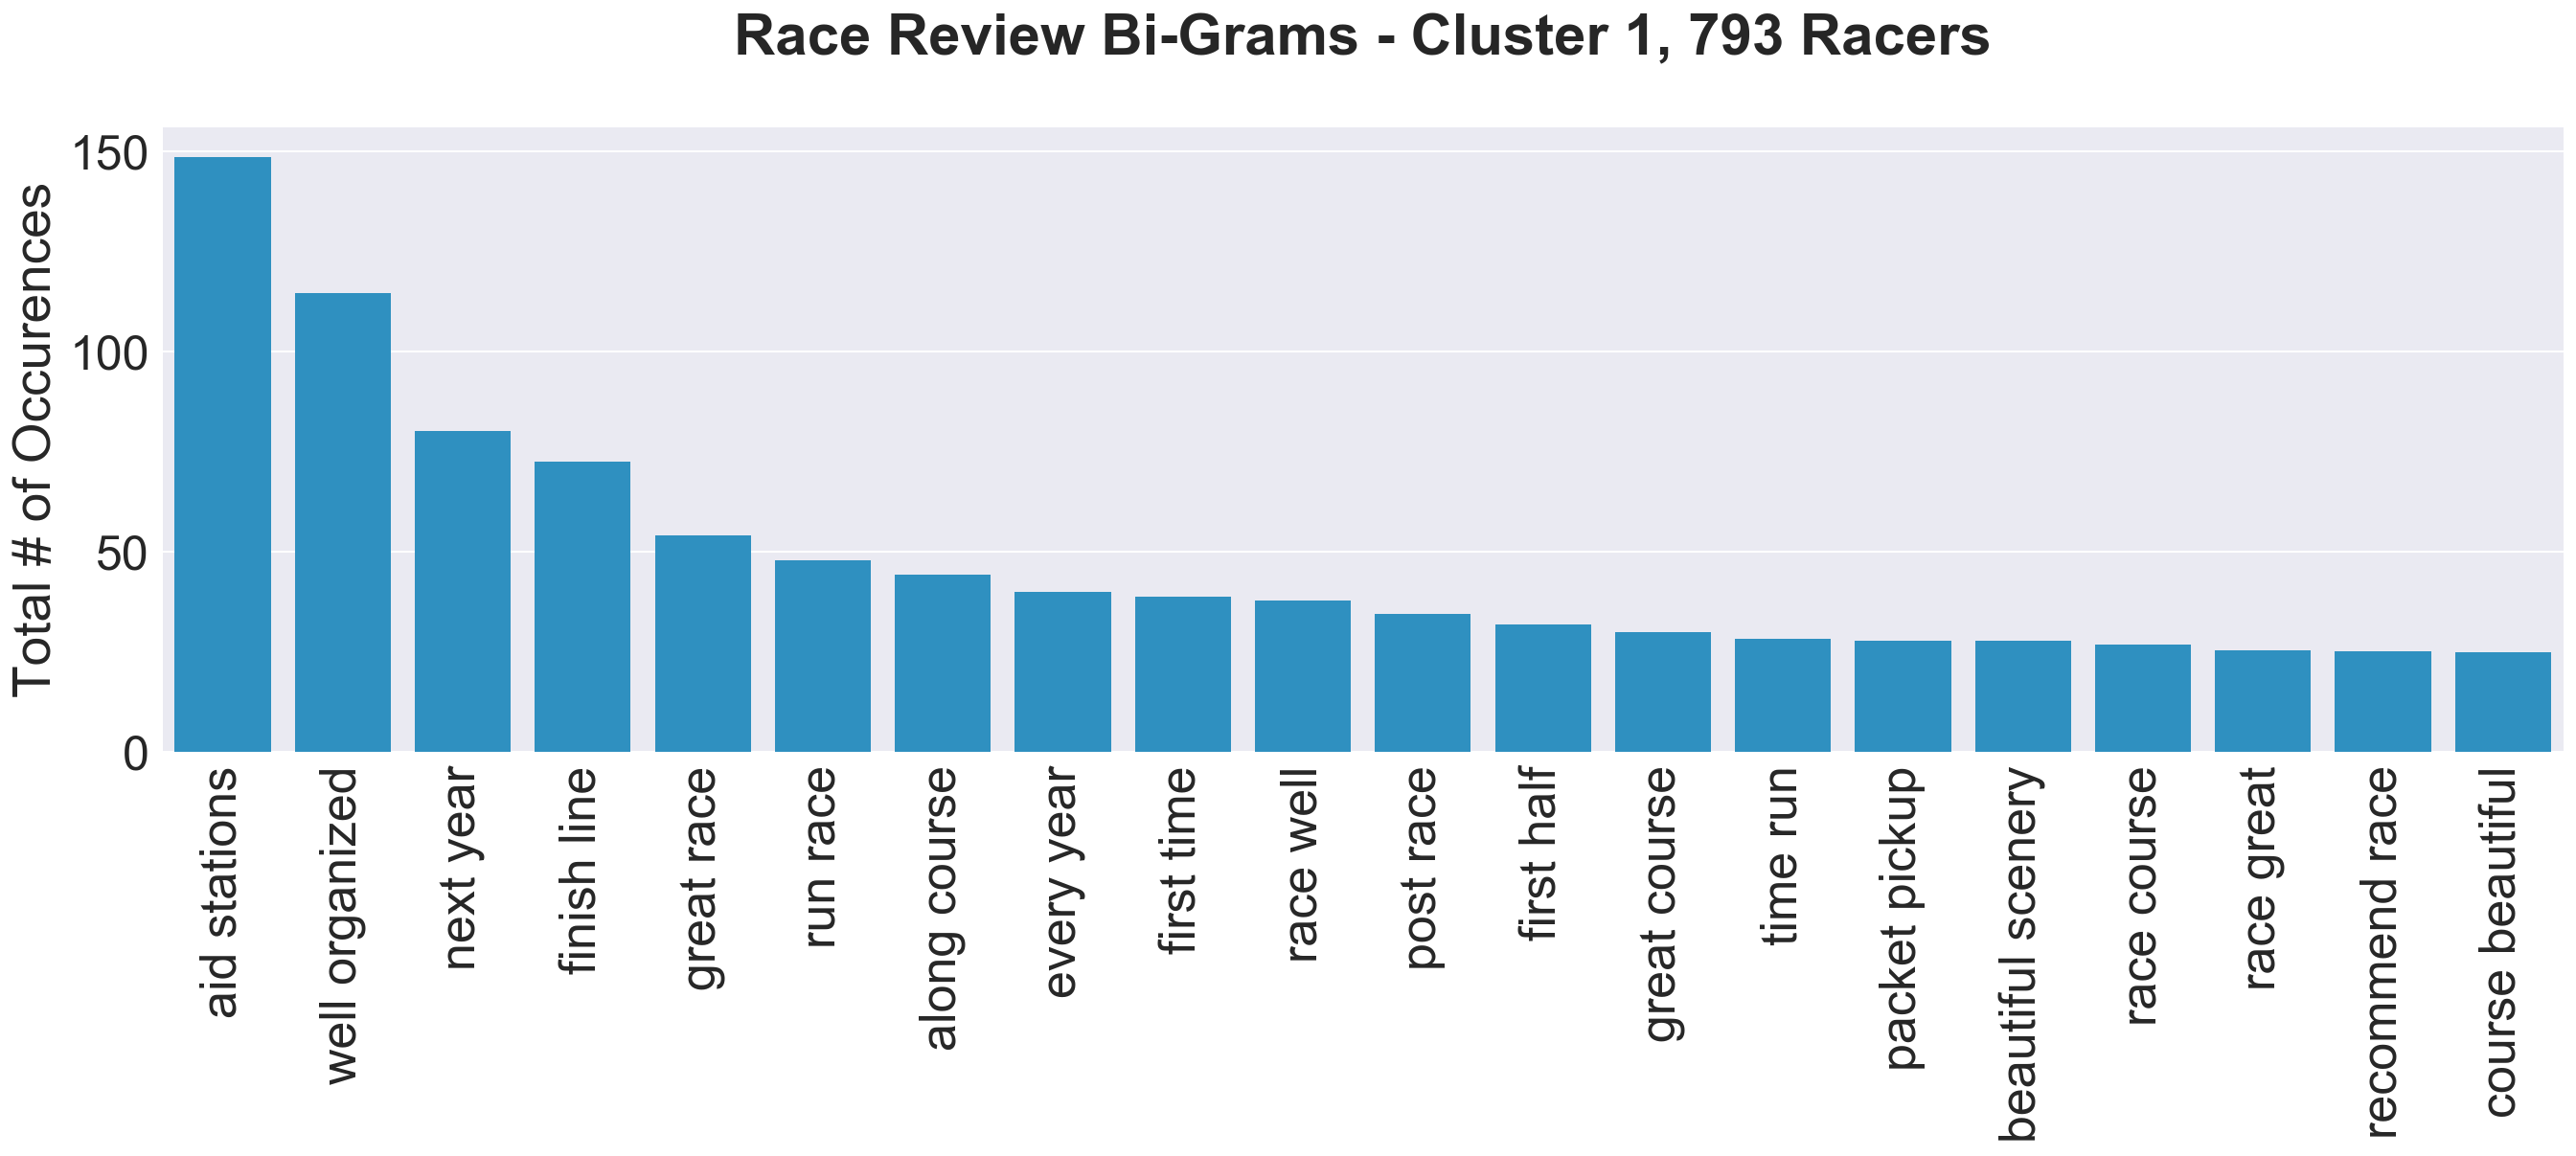

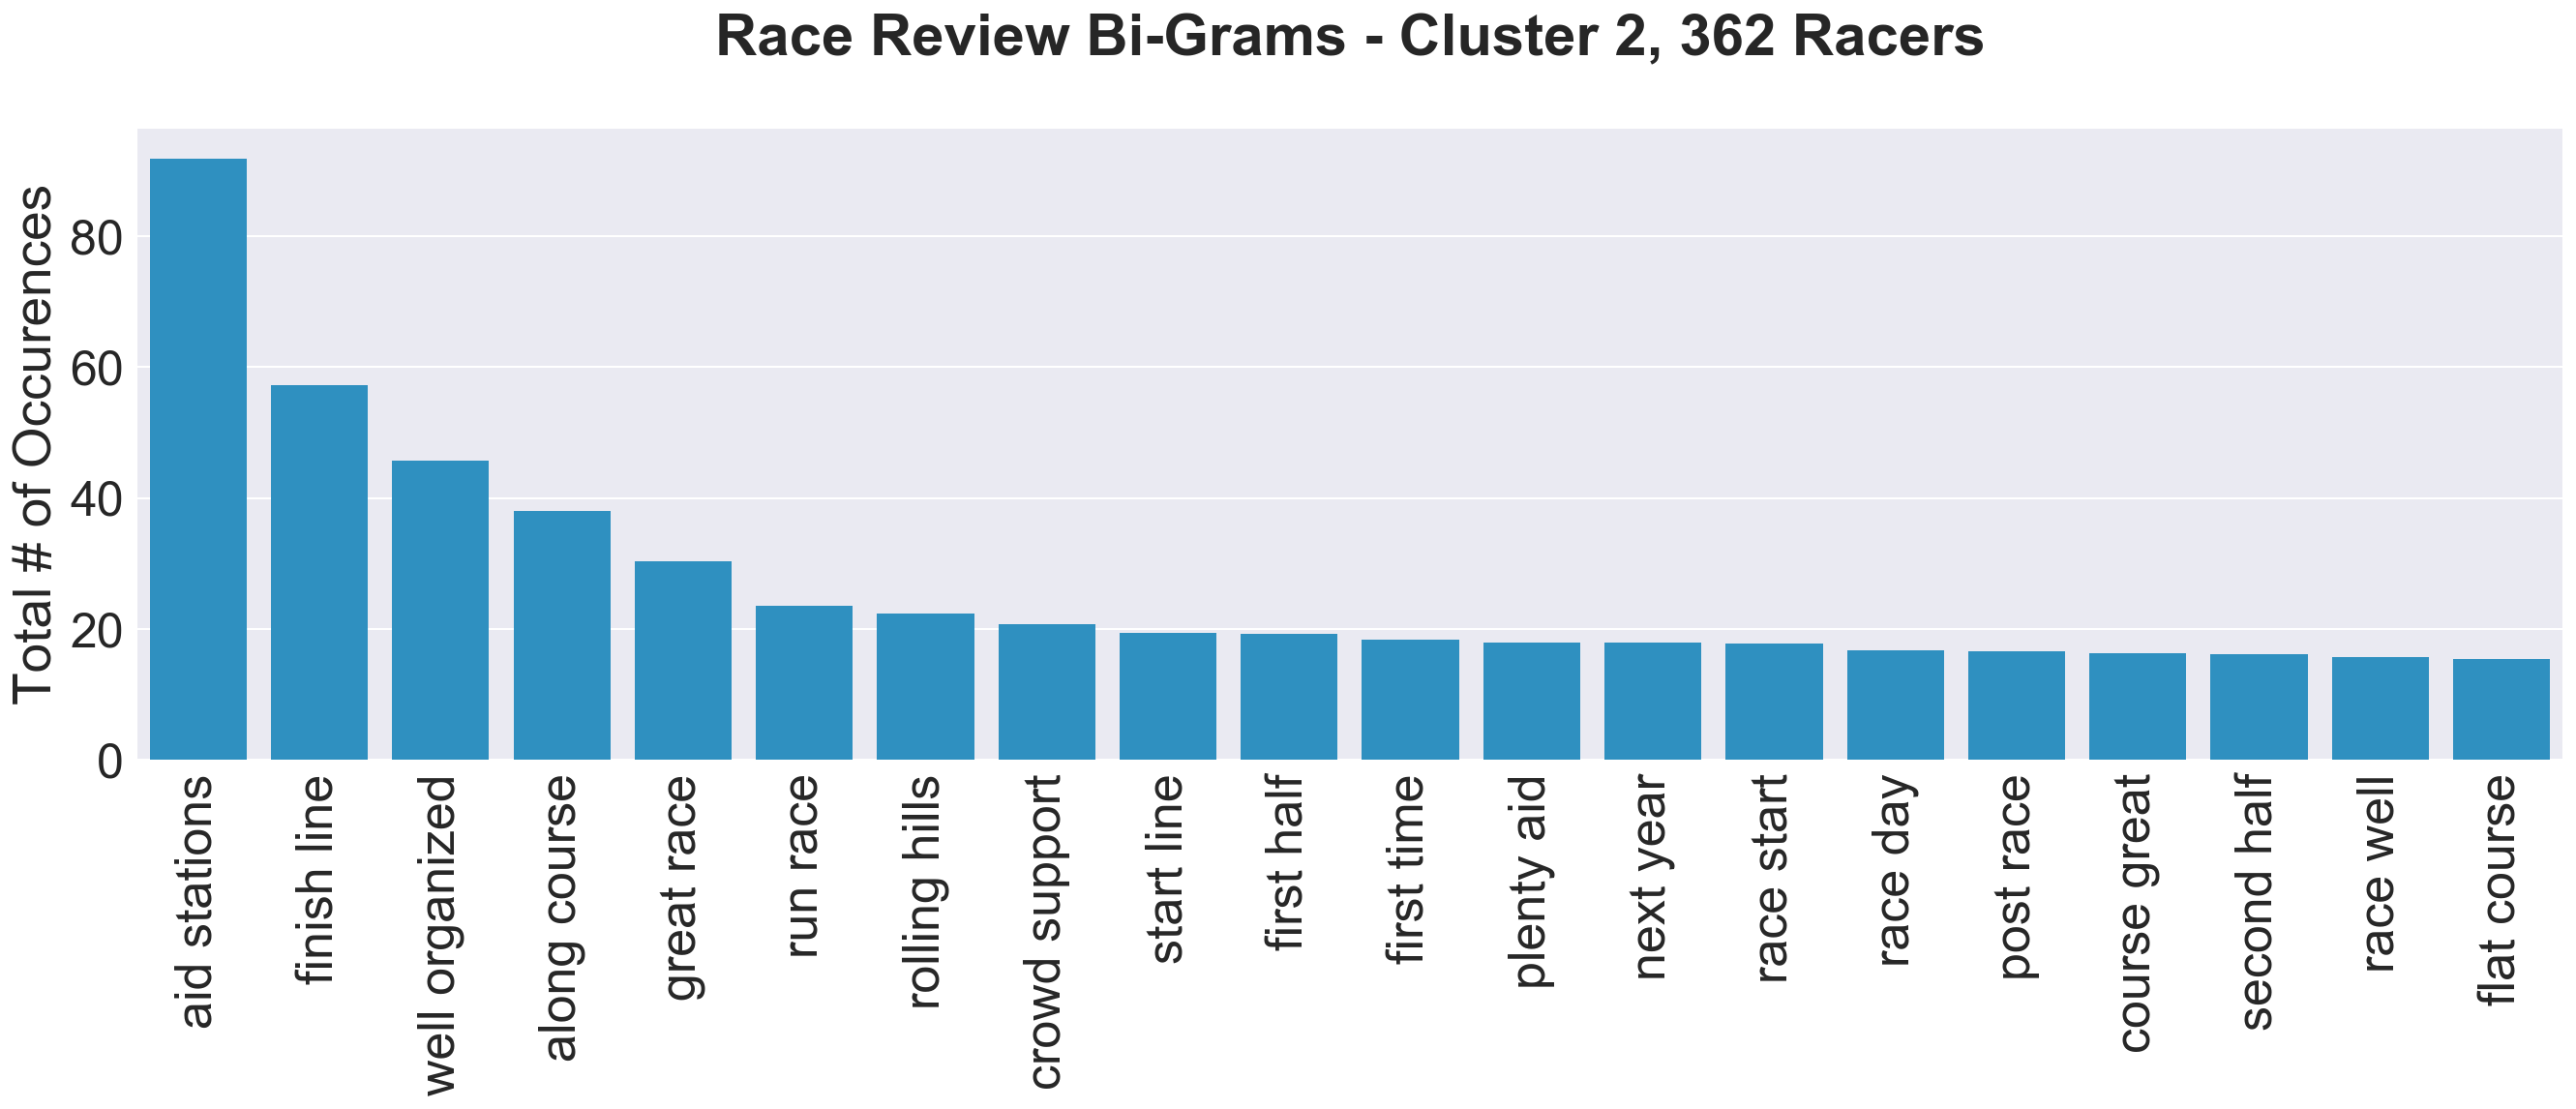

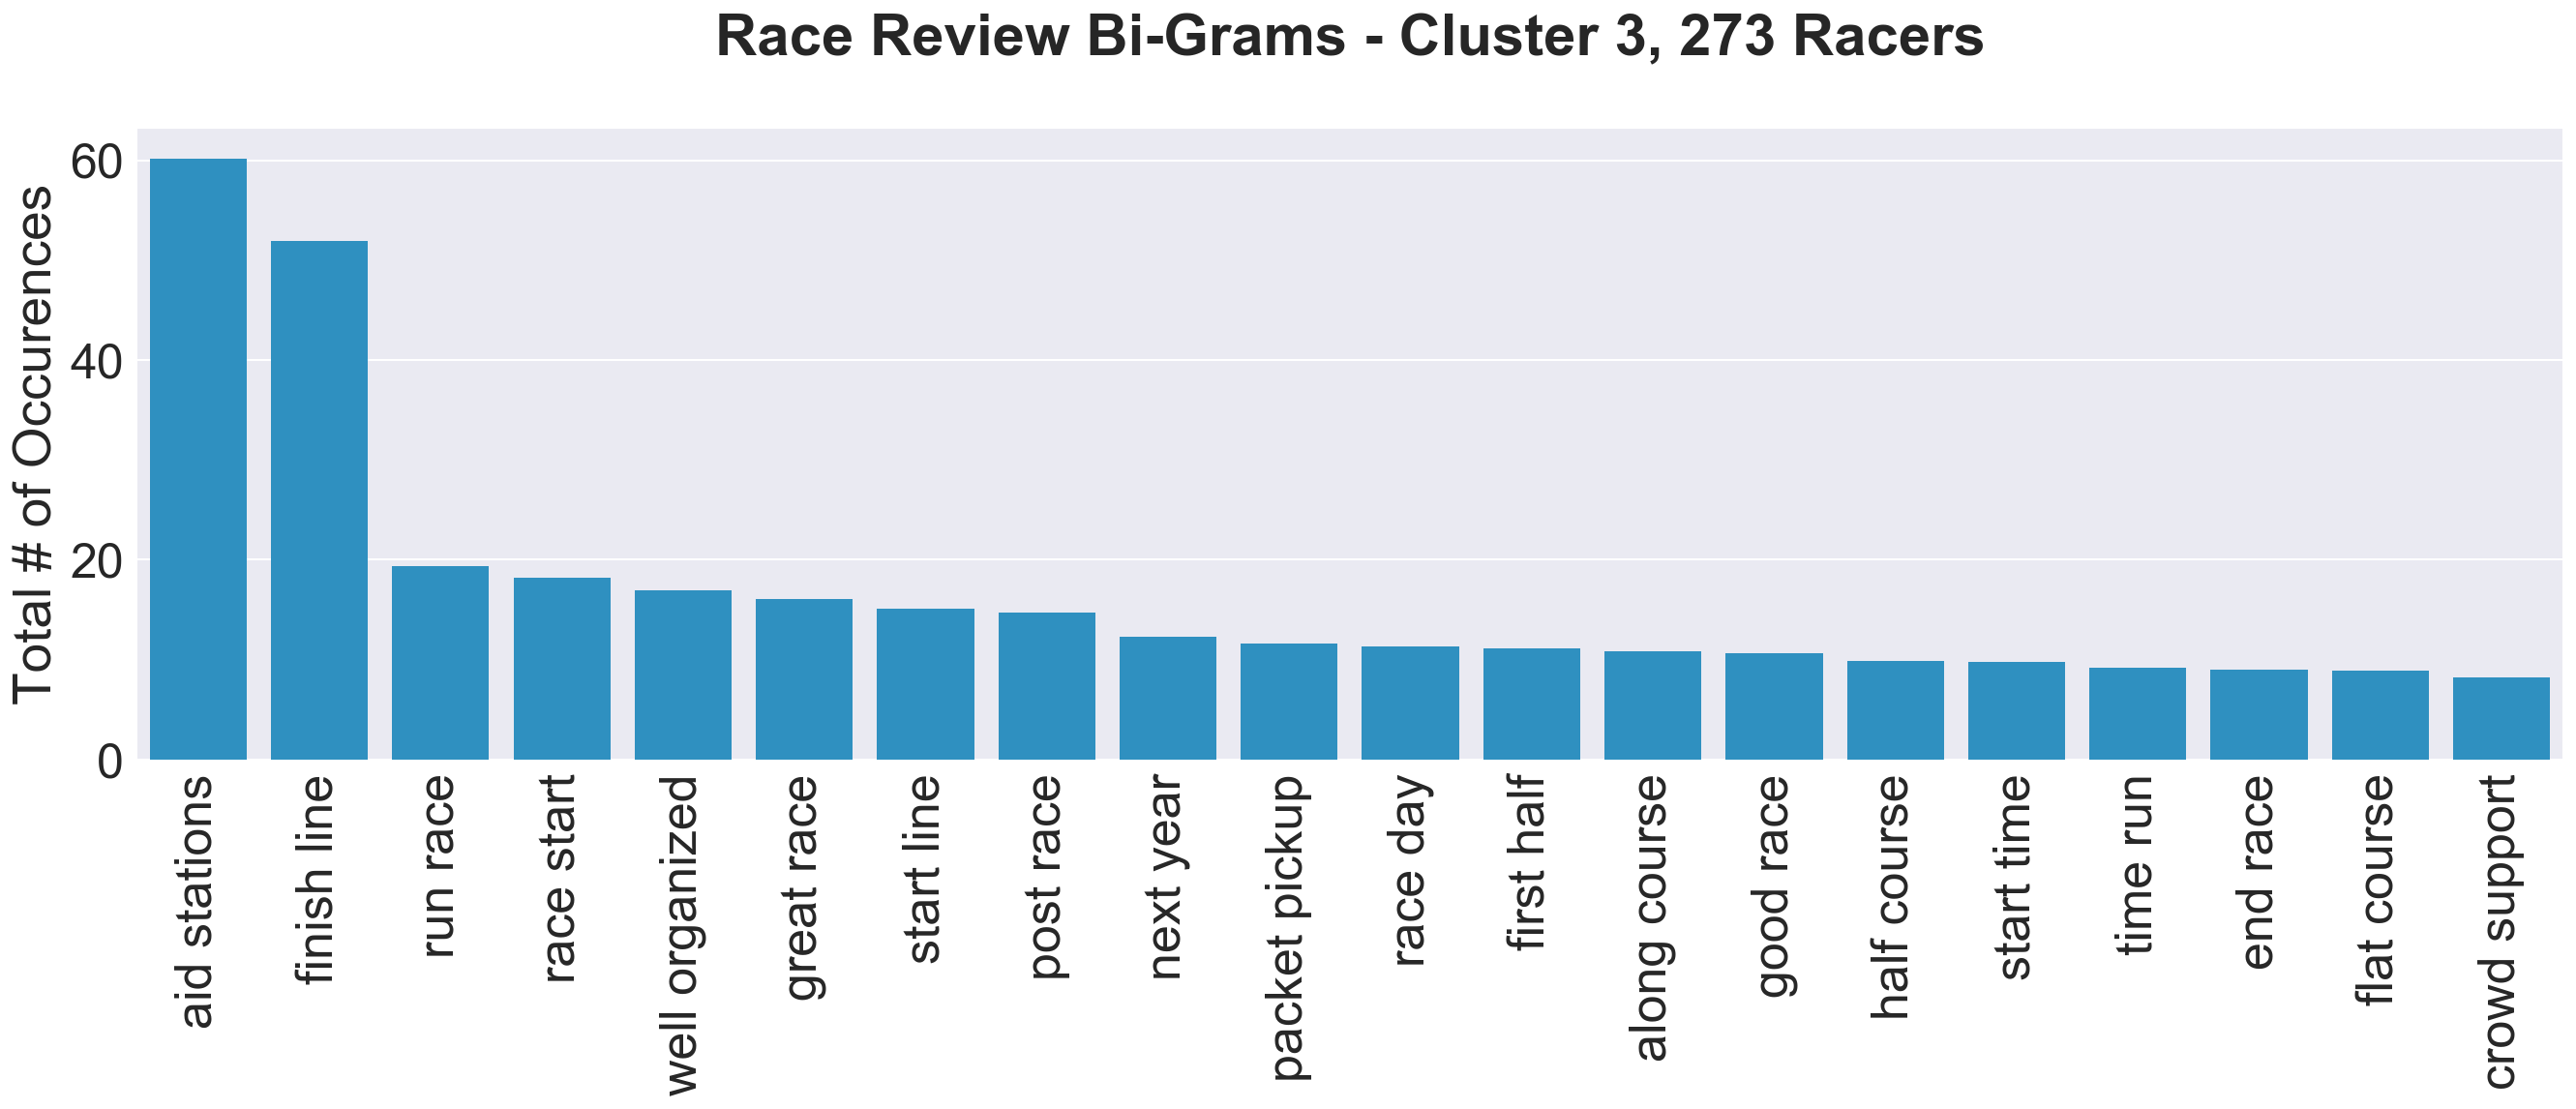

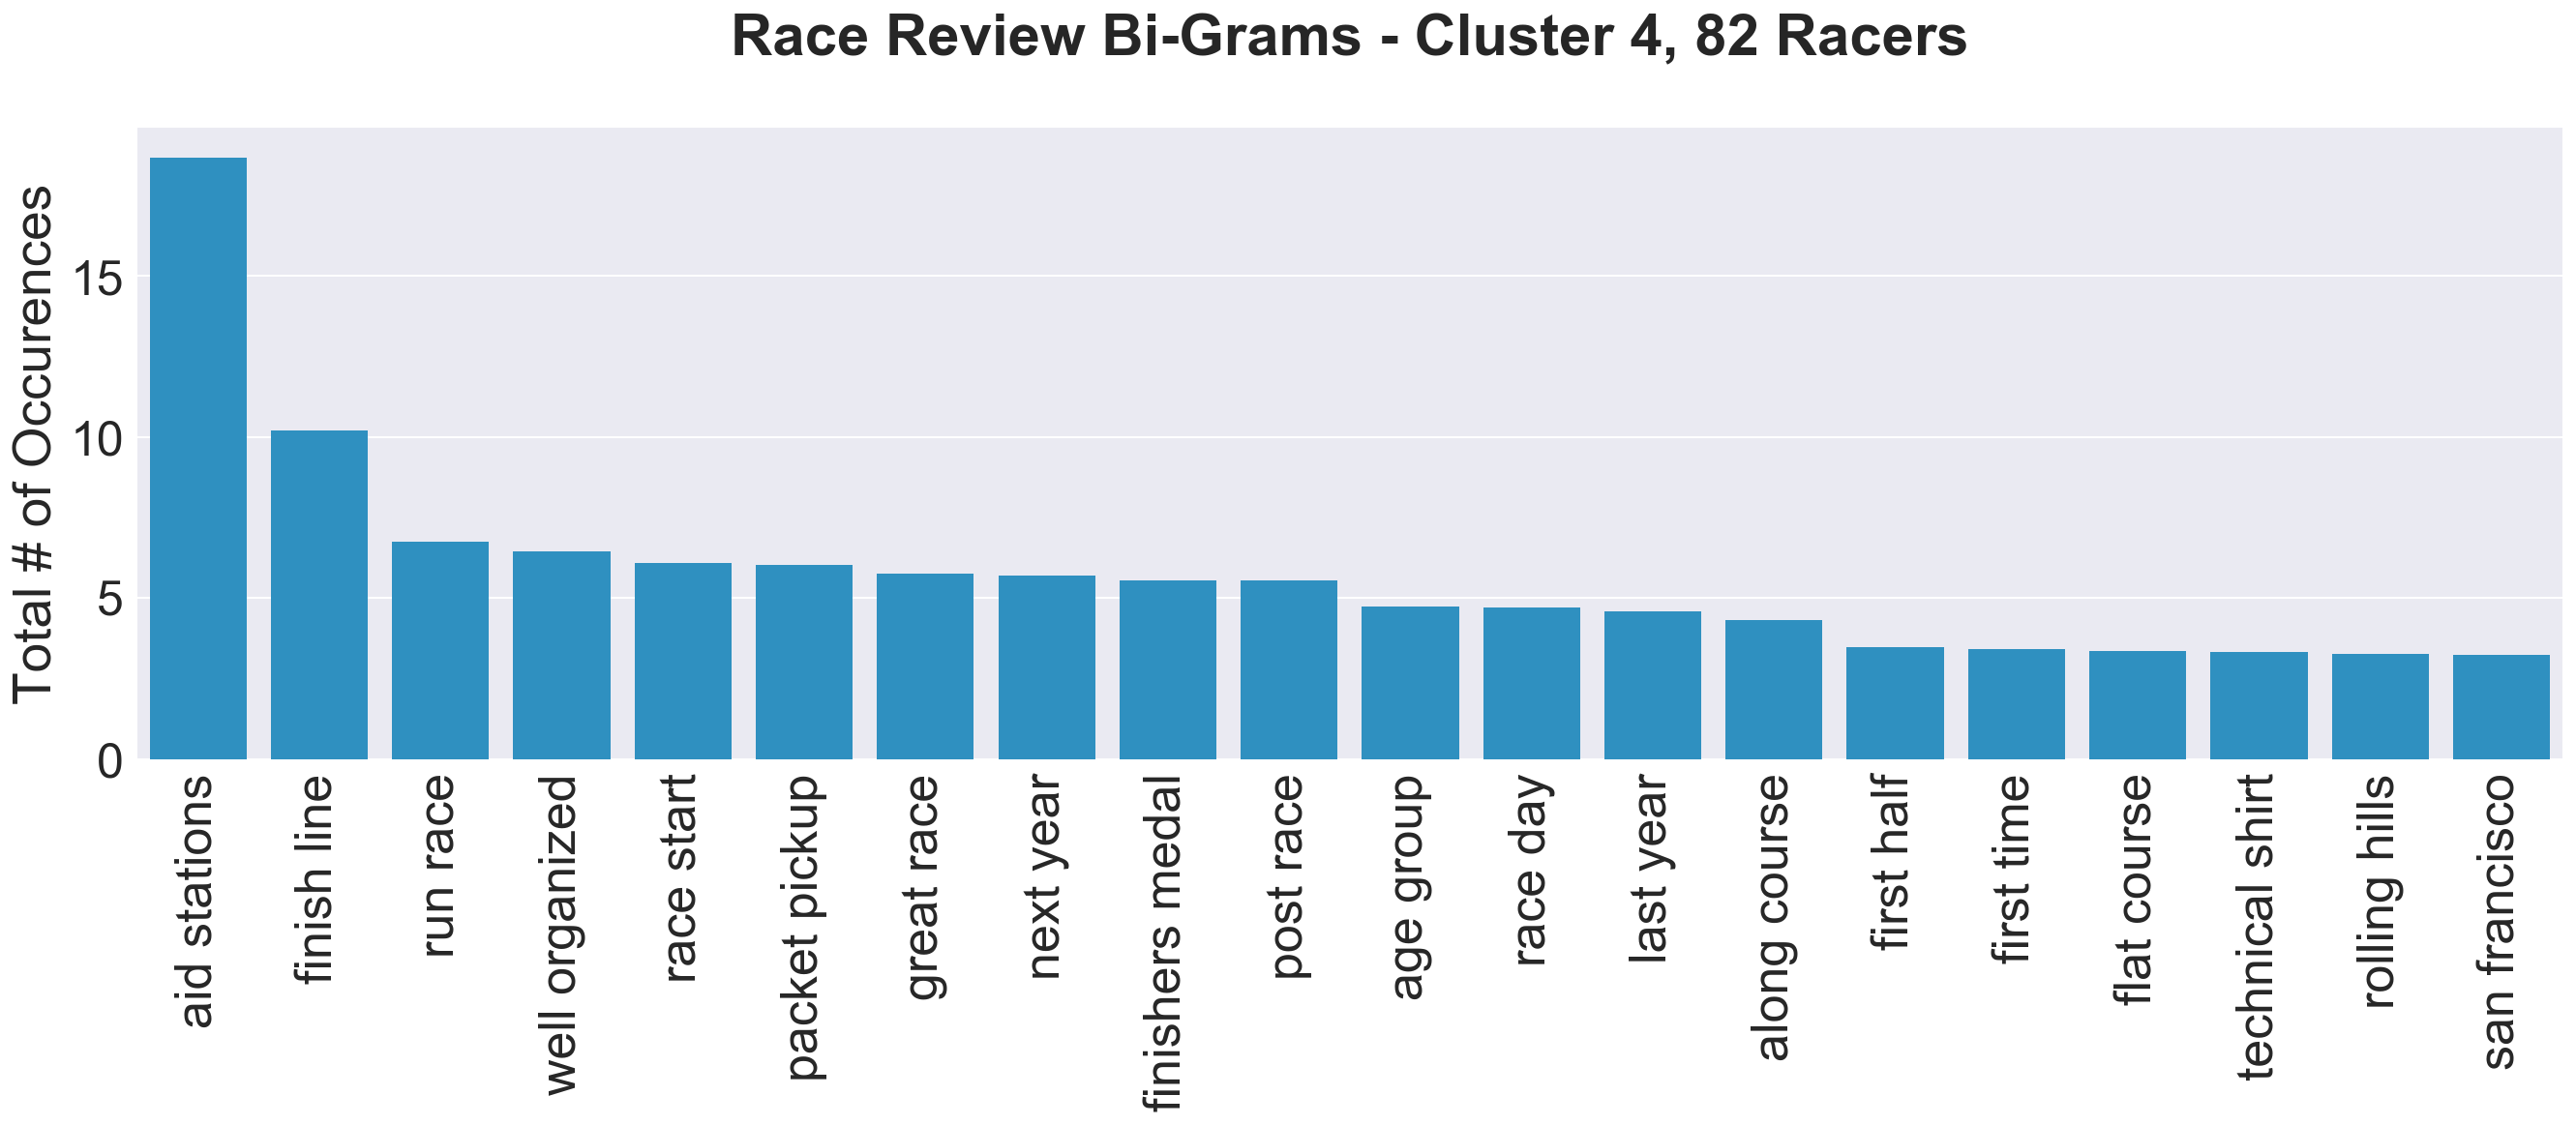

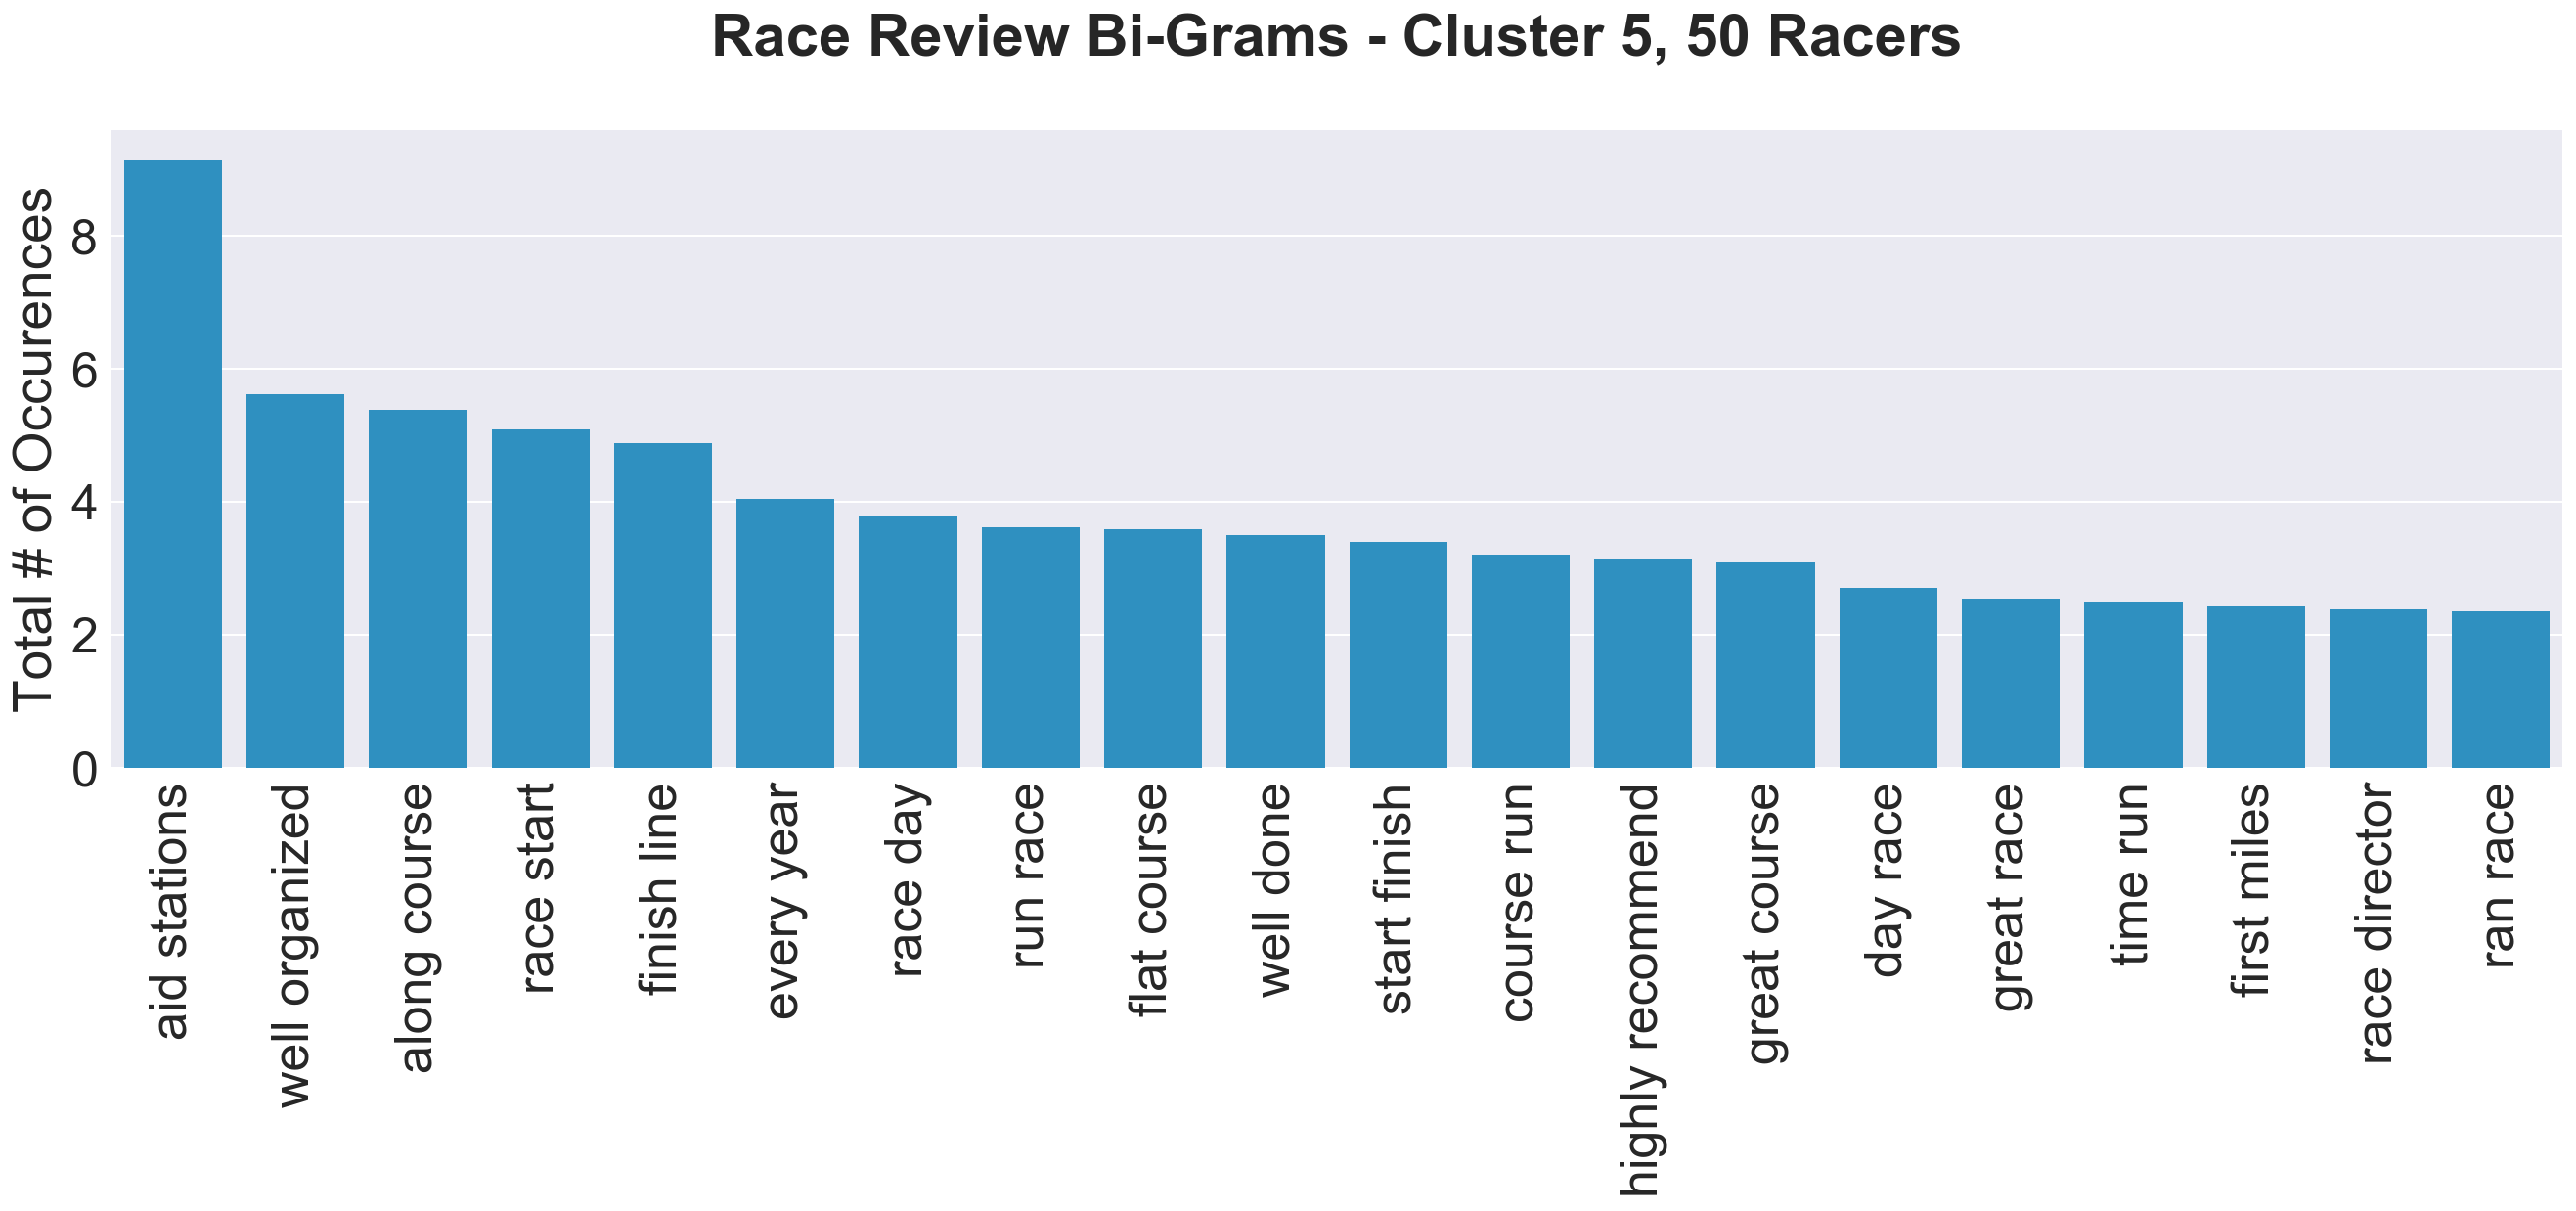

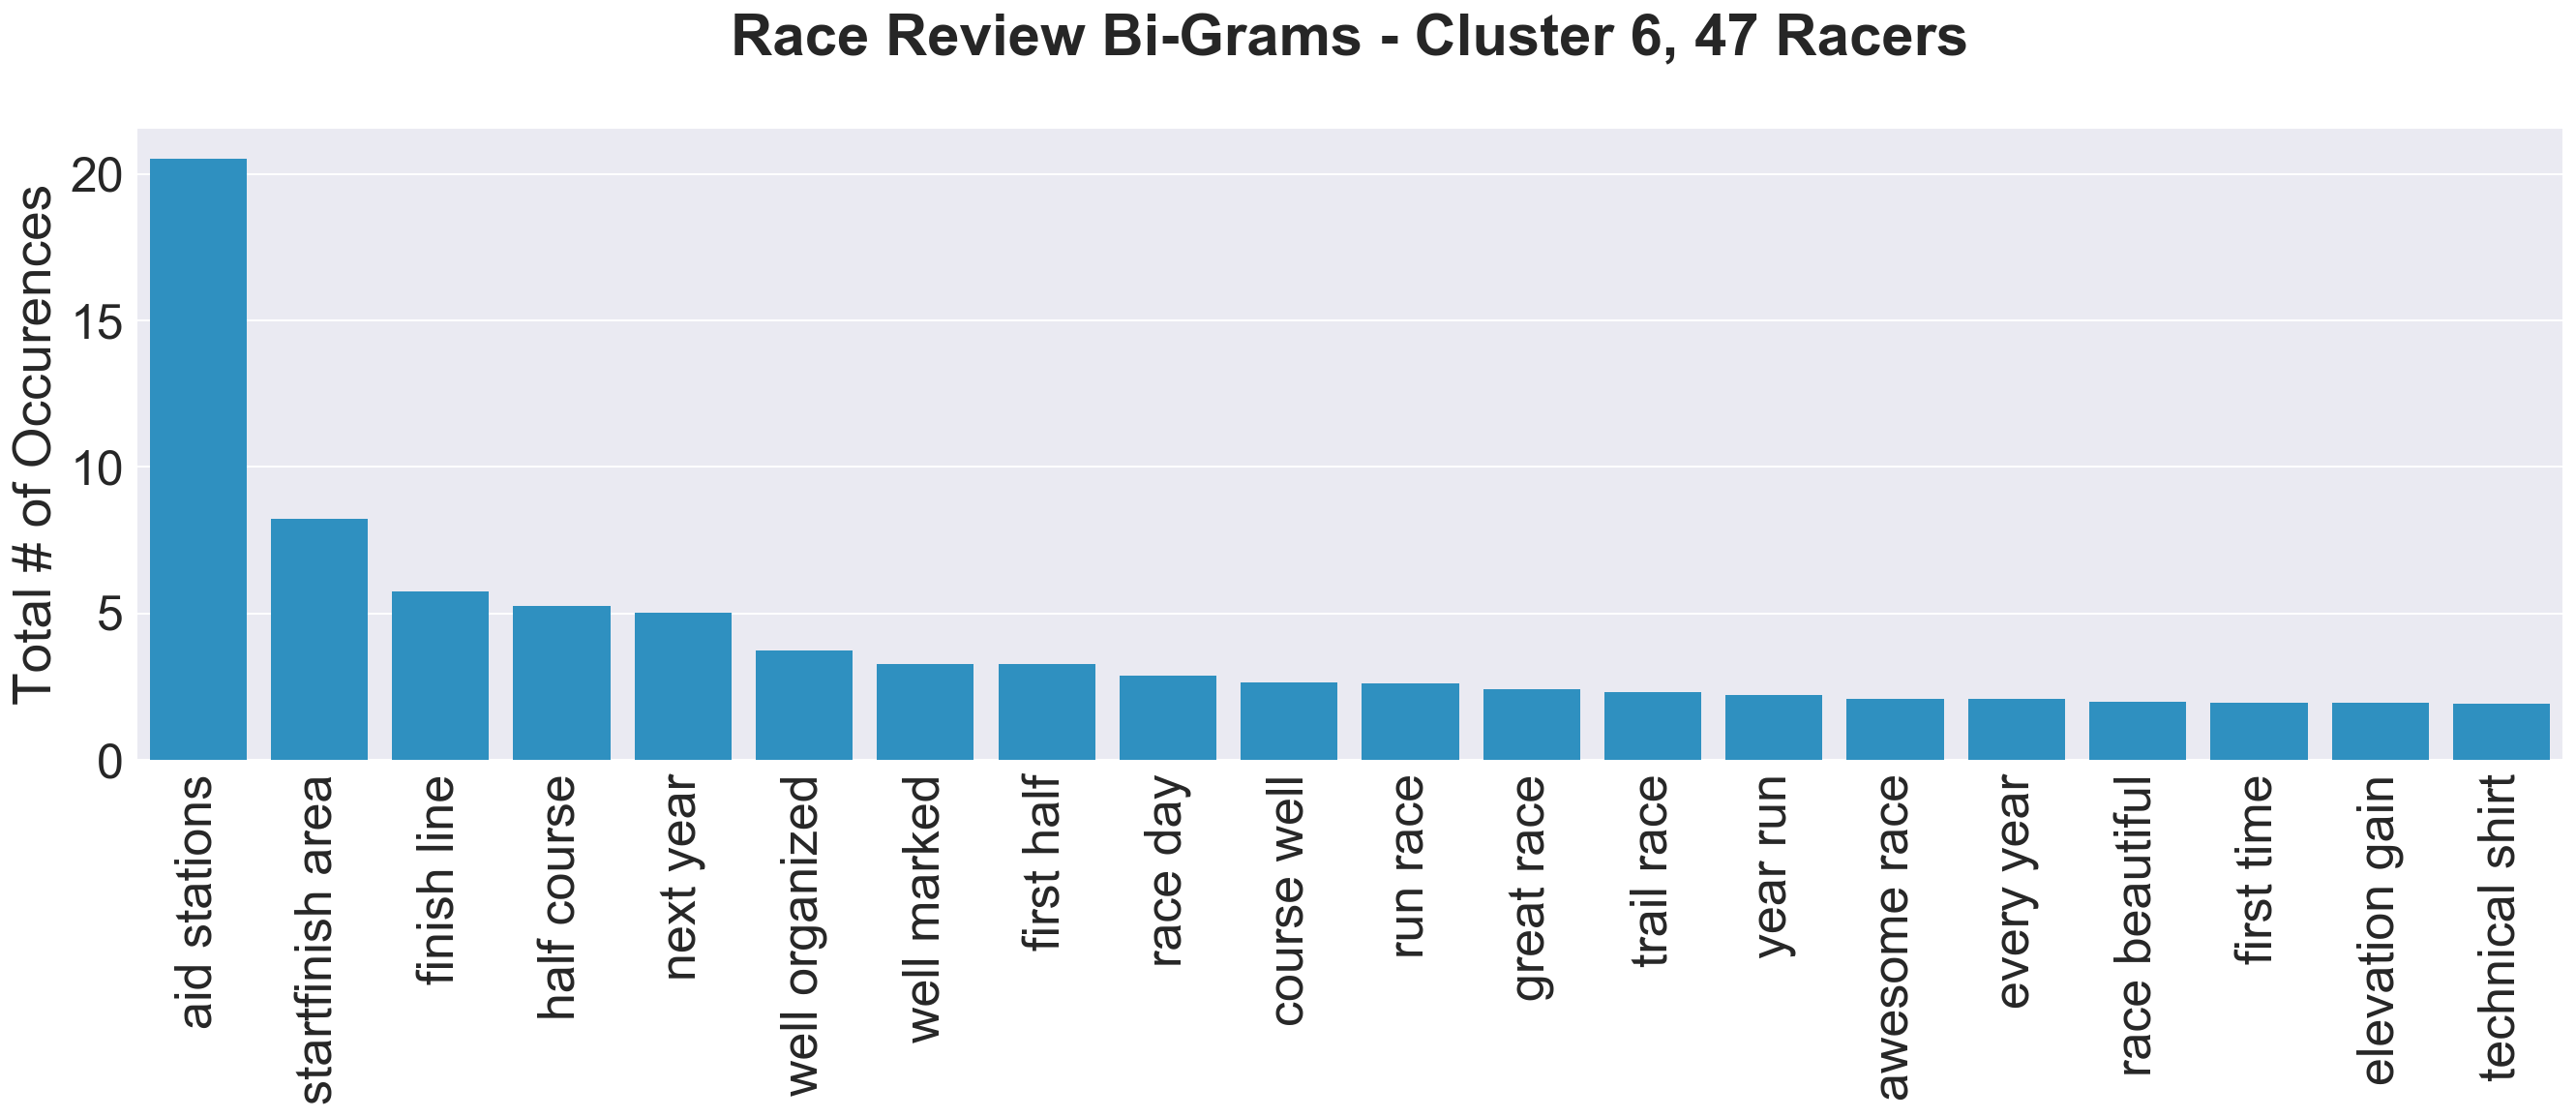

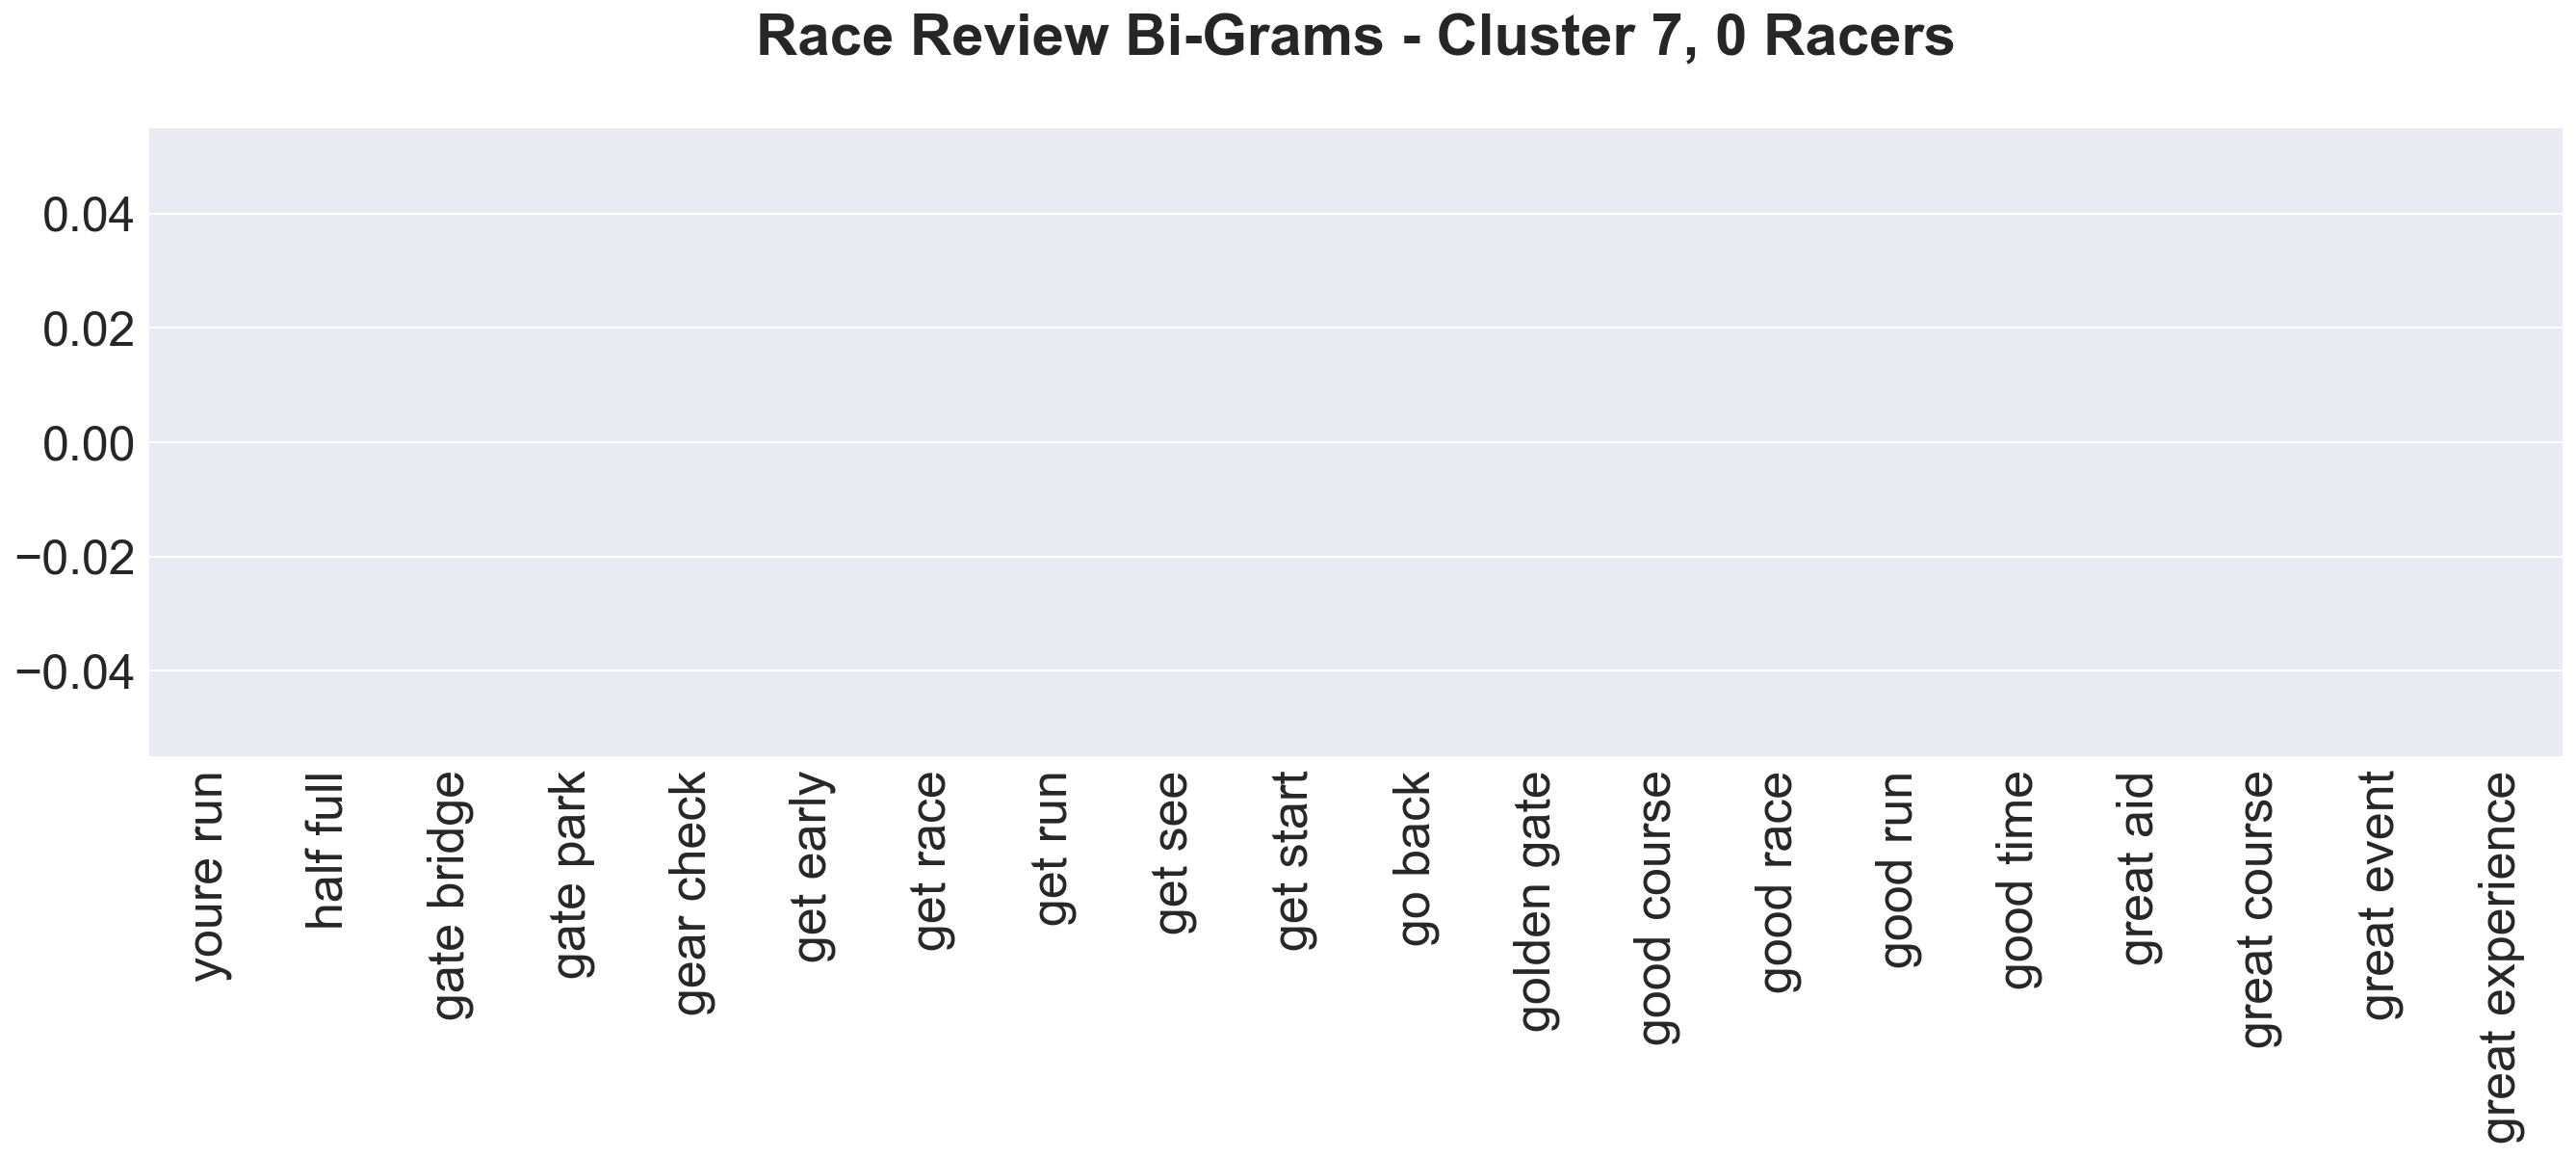

In [178]:
cluster_vect = pd.concat([racer_with_topics['kmean_clusters'], racer_combined_vect], axis=1)
for cluster_num in range(1,8):
    cluster = cluster_vect[cluster_vect['kmean_clusters'] == cluster_num]
    num_racers = len(cluster)
    cluster = cluster.drop('kmean_clusters', axis=1)
    cluster_sum = cluster.sum(axis=0)
    cluster_top30 = cluster_sum.sort_values(ascending=False).head(20)
    plt.figure(figsize=(20, 6))
    sns.set(font_scale=2.5)
    bigram_plot.set(ylabel='Total # of Occurences')
    bigram_plot = sns.barplot(cluster_top30.index, \
                              cluster_top30.values, color='#1798d8')
    bigram_plot.set_title("Race Review Bi-Grams - Cluster {}, {} Racers\n" \
                          .format(cluster_num, num_racers), fontsize=30, weight='bold')
    bigram_plot.set_xticklabels(labels=cluster_top30.index, rotation=90, fontsize=26)
    plot_file = './plots/cluster_bigrams_cluster' + str(cluster_num)
    plt.savefig(plot_file, dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

Finally, now that we have recognizable clusters and a race recommender, we can marry the two. Let's apply the topics to the top recommended races and see how the hit rates look by cluster.

In [245]:
hits_top1_clusters = pd.merge(left=hits_top1, right=racer_with_topics, on='racer_id')
hits_top1_clusters['kmean_clusters'].value_counts() / racer_with_topics['kmean_clusters'].value_counts()

1    0.089533
2    0.143646
3    0.128205
4    0.158537
5    0.080000
6    0.148936
Name: kmean_clusters, dtype: float64

In [246]:
hits_top5_clusters = pd.merge(left=hits_top5, right=racer_with_topics, on='racer_id')
hits_top5_clusters['kmean_clusters'].value_counts() / racer_with_topics['kmean_clusters'].value_counts()

1    0.175284
2    0.281768
3    0.278388
4    0.621951
5    0.260000
6    0.382979
Name: kmean_clusters, dtype: float64

Not surprisingly, the race recommender gets a higher hit rate for users with more reviews. In particular, the most engaged reviewers (Cluster 4) had a hit rate of 62%. Thus we can conclude that matching on topics does a good job of finding the races that a racer is likely to run when that racer submits more reviews.

## Appendix
### Further Validation - Pulling examples to review on RaceRaves.com
Finally, we can explore the data for some concrete examples to ensure that recommended races make sense for individual runners. Below are a couple of examples that proved to be helpful.

In [184]:
recommended_with_clusters = pd.merge(left=recommended_races, 
                                     right=racer_with_topics[['racer_id', 'kmean_clusters']],
                                     on='racer_id')
recommended_with_clusters.sample(20, random_state=706)

,racer_id,Race1,Race2,Race3,Race4,Race5,kmean_clusters
1577,watsonfam5,Ragnar Relay Washington DC,Harpeth Hills Flying Monkey Marathon,Santa Monica Venice Christmas Run,Harvest Half Marathon,Belgrade Marathon,3
416,alyciaz,Ermstal-Marathon,Liberty Hospital Half Marathon,"Toronto 10 Miler, 5K & Half Marathon",Laguna Hills Road Runner Sports Adventure Run ...,Reach Race for Independence,3
1368,runninginpink,Halloween Half Marathon – Miami Beach,School Ghoul Run Los Alamitos,Polar Night Half Marathon,Stadtwerke Bochum Half Marathon,Too Cold to Hold Half Marathon,1
651,dmodeman,Angel Island 5 Miler & Half Marathon,Lake Powell Half Marathon (Vacation Races),Salt Lake City Marathon,Mississippi River Marathon & Half Marathon,Great Smoky Mountains Half Marathon (Vacation ...,2
756,grizmiler,Gopher to Badger Half Marathon and 5K,Hilton Head Island Marathon and Half,Bagan Temple Marathon,Quarry Turkey Half Marathon/10K/5K & Little Tu...,City of Laguna Hills Memorial Day Half Maratho...,2
17,Amyew,Wulfman’s CDT,Ragnar Relay So Cal,Hartford Marathon & Half Marathon,Saints and Sinners Half Marathon & Relay,Vineyard Vines Half Marathon at Pebble Beach,3
100,GaryC,Ahmanson Trails 12K/6K,Angus Glen Spring Ten Miler,Apple Blossom Races,Auffahrtslauf St. Gallen,Bay of Fundy International Marathon,1
179,Keeponrollin,Adams County Marathon (Run with the Amish),C&D Canal Half Marathon,Milwaukee Running Festival,Tamarindo Beach Marathon,"Wicked Half Marathon, 4 Mile and Spooky Sprint...",1
894,jon_adams7,Town of Celebration Marathon & Half Marathon,Morgan Hill Run & Bike Festival,Fargo Mini Marathon,Portland Marathon,Livermore Half Marathon,1
126,IRun2live,Bad Bass Half Marathon/10K/5K,Shamrock Run Portland,Ahmanson Trails 12K/6K,Angus Glen Spring Ten Miler,Apple Blossom Races,4


In [249]:
racer_id = 'dlu975'
cluster1_example = racer_with_topics[racer_with_topics['racer_id'] == racer_id].reset_index()
cluster1_example[topic_columns].T.sort_values(0, ascending=False)[0:10]

,0
Topic_5,0.133100
Topic_26,0.128501
Topic_18,0.095357
Topic_29,0.068817
Topic_1,0.068817
Topic_22,0.068529
Topic_16,0.055628
Topic_12,0.052688
Topic_23,0.052676
Topic_27,0.042136


In [250]:
cluster1_race1 = recommended_with_clusters[recommended_with_clusters['racer_id'] == racer_id]['Race1'].values[0]
cluster1_example_race = race_with_topics[race_with_topics['race_name'] == cluster1_race1].reset_index()
cluster1_example_race[topic_columns].T.sort_values(0, ascending=False)[0:10]

,0
Topic_23,0.137178
Topic_18,0.126028
Topic_5,0.100248
Topic_26,0.088535
Topic_19,0.054773
Topic_7,0.054117
Topic_29,0.049954
Topic_2,0.041181
Topic_9,0.034565
Topic_25,0.034290


In [257]:
racer_id = 'dwaynejarrell'
me_example = racer_with_topics[racer_with_topics['racer_id'] == racer_id].reset_index()
me_example[topic_columns].T.sort_values(0, ascending=False)[0:10]

,0
Topic_27,0.238614
Topic_23,0.169444
Topic_7,0.096310
Topic_14,0.090075
Topic_8,0.086111
Topic_2,0.086111
Topic_25,0.086111
Topic_0,0.086111
Topic_26,0.002778
Topic_17,0.002778


In [258]:
me_race1 = recommended_with_clusters[recommended_with_clusters['racer_id'] == racer_id]['Race1'].values[0]
me_example_race = race_with_topics[race_with_topics['race_name'] == me_race1].reset_index()
me_example_race[topic_columns].T.sort_values(0, ascending=False)[0:10]

,0
Topic_23,0.176120
Topic_27,0.082354
Topic_17,0.063866
Topic_18,0.057098
Topic_29,0.050616
Topic_2,0.048909
Topic_16,0.047159
Topic_15,0.042940
Topic_7,0.034628
Topic_6,0.034211


In [259]:
race_with_topics[race_with_topics['race_name'] == me_race1]

,race_name,num_reviews,num_distances,10 Miler,10K,12K,15K,25K,4 Miler,5 Miler,...,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29
741,Kaiser Permanente San Francisco Half Marathon ...,31,2,0,0,0,0,0,0,0,...,0.025479,0.026916,0.021725,0.17612,0.026942,0.010873,0.010874,0.082354,0.016221,0.050616


In [260]:
recommended_races[recommended_races['racer_id'] == racer_id]

,racer_id,Race1,Race2,Race3,Race4,Race5
678,dwaynejarrell,Kaiser Permanente San Francisco Half Marathon ...,San Francisco Marathon,Quicksilver Trail Challenge,Madison Marathon (MT),Bridge to Bridge Run
